In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import json

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
DEVICE = 'cpu'
from sklearn import metrics
from scipy.special import softmax

In [2]:
with open("../data/synthetic_data/large_synthetic_data_aggregate.json") as f:
    data = json.load(f)

In [3]:
all_sequence_lens = []
all_annotations = []

human_to_trial_num_to_sequence = {}
min_len_seq = 0
max_len_seq = 0

for case_id in data:
    human_id = int(case_id.split(".")[0])
    trial_id = 1
#     trial_id = int(case_id.split(".")[1])
    
    if human_id not in human_to_trial_num_to_sequence:
        human_to_trial_num_to_sequence[human_id] = {}
        
    human_to_trial_num_to_sequence[human_id][trial_id] = data[case_id]
    
    for elem in data[case_id]:
        if elem not in all_annotations:
            all_annotations.append(elem)
            
    all_sequence_lens.append(len(data[case_id]))
    
    

In [4]:
max(all_sequence_lens)

19

In [5]:
num_to_annot = dict(enumerate(all_annotations))
annot_to_num = {v: k for k, v in num_to_annot.items()}
number_of_annots = len(all_annotations)

In [6]:
len(human_to_trial_num_to_sequence)

100000

In [7]:
number_of_seqs_to_use = 300

In [8]:
human_to_trial_num_to_traj = {}

for human_id in range(number_of_seqs_to_use):
    human_to_trial_num_to_traj[human_id] = {}
    for trial_id in human_to_trial_num_to_sequence[human_id]:
        human_to_trial_num_to_traj[human_id][trial_id] = []
        
        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]
        
        for i in range(len(seq)):
            annot_idx = annot_to_num[seq[i]]
            current_state[annot_idx] = current_state[annot_idx] + 1
            
            normalized_current_state = [elem/sum(current_state) for elem in current_state]
            
            human_to_trial_num_to_traj[human_id][trial_id].extend(normalized_current_state)
            
        for i in range(len(seq), max(all_sequence_lens)):
            annot_idx = annot_to_num['end']
            current_state[annot_idx] = current_state[annot_idx] + 1
            
#             human_to_trial_num_to_traj[human_id][trial_id].extend(current_state)
            
            normalized_current_state = [elem/sum(current_state) for elem in current_state]
            
            human_to_trial_num_to_traj[human_id][trial_id].extend(normalized_current_state)
        
    
    

# Create AE

In [9]:
class Autoenc(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
         torch.nn.Linear(361, 64),
         torch.nn.ReLU(),
#          torch.nn.Linear(128, 64),
#          torch.nn.ReLU(),
         torch.nn.Linear(64, 36),
         torch.nn.ReLU(),
         torch.nn.Linear(36, 18),
         torch.nn.ReLU(),
         torch.nn.Linear(18, 2)
      )

        self.decoder = torch.nn.Sequential(
         torch.nn.Linear(2, 18),
         torch.nn.ReLU(),
         torch.nn.Linear(18, 36),
         torch.nn.ReLU(),
         torch.nn.Linear(36, 64),
         torch.nn.ReLU(),
#          torch.nn.Linear(64, 128),
#          torch.nn.ReLU(),
         torch.nn.Linear(64, 361),
#          torch.nn.Sigmoid()
      )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [10]:
for human_id in human_to_trial_num_to_traj:
    for trial_id in human_to_trial_num_to_traj[human_id]:
        human_to_trial_num_to_traj[human_id][trial_id] = np.expand_dims(np.expand_dims(human_to_trial_num_to_traj[human_id][trial_id],0), 0)
        
#         print((human_to_trial_num_to_traj[human_id][trial_id]).shape)

# Reconstruct Original

In [11]:
model = Autoenc()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [12]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for human_id in list(human_to_trial_num_to_traj.keys())[:10]:
        for i in [1]:
            first_traj = human_to_trial_num_to_traj[human_id][i]

            first_traj = Variable(torch.Tensor(first_traj)).to(device=DEVICE)

            reconstructed = model(first_traj)

            loss = loss_function(reconstructed, first_traj)
#             print("loss", loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss)
    outputs.append((epochs, first_traj, reconstructed))
    

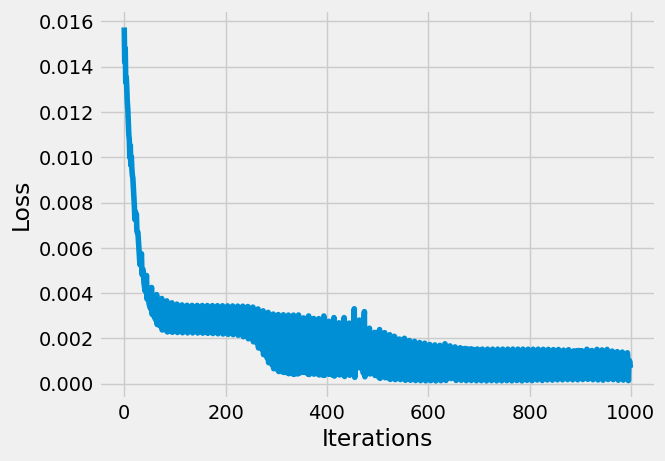

In [13]:

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot([elem.detach().numpy() for elem in losses[:]])
plt.show()

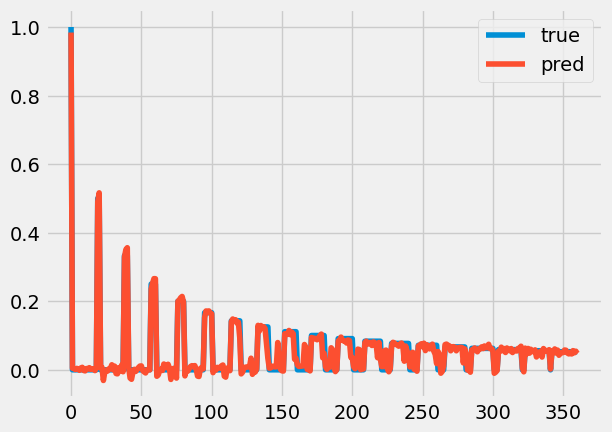

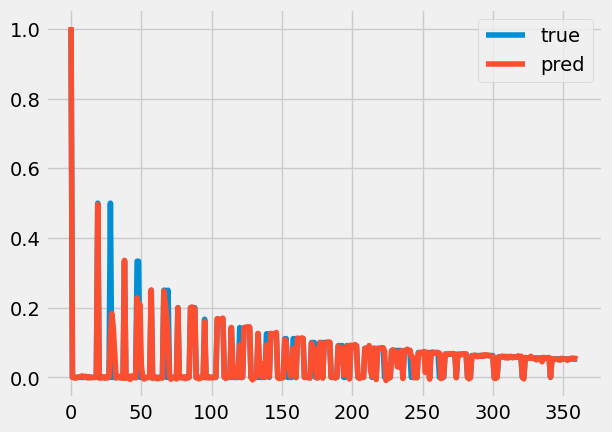

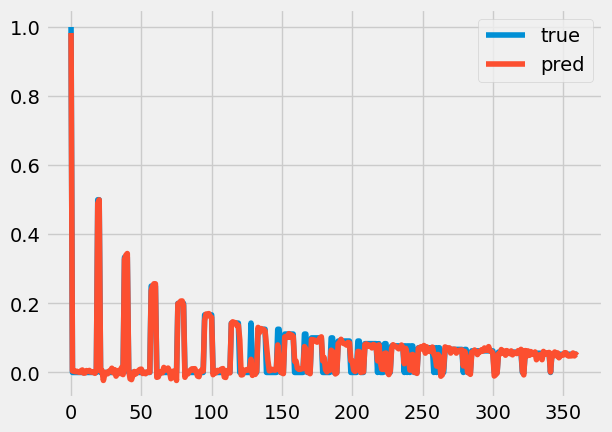

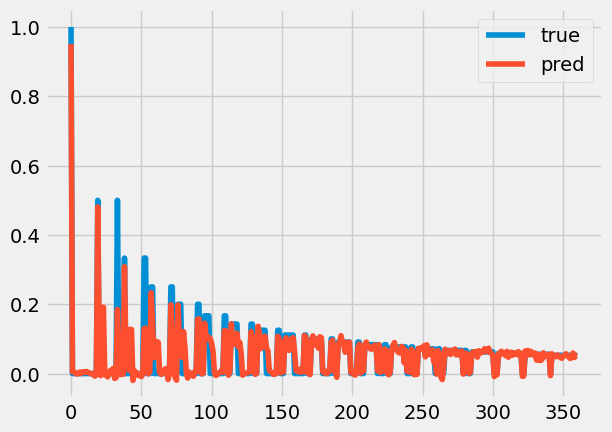

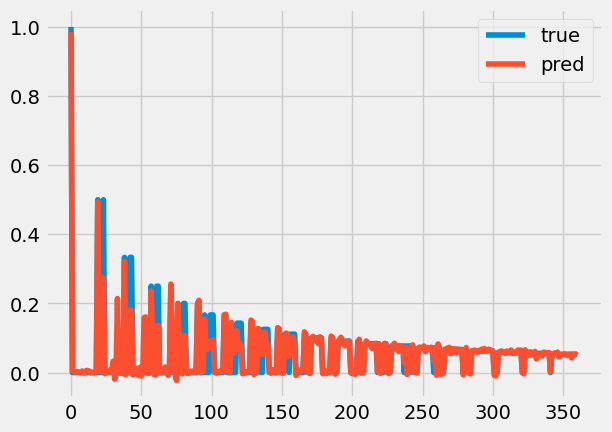

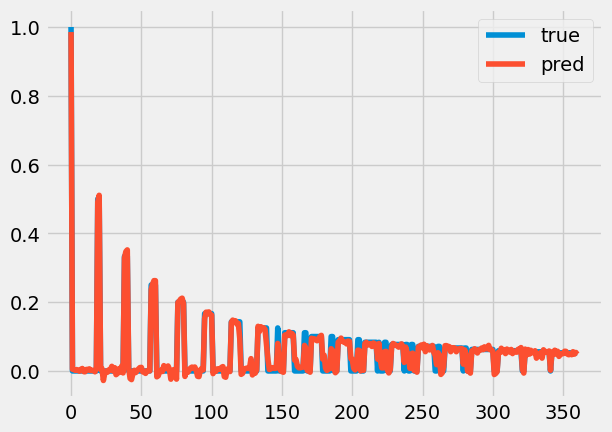

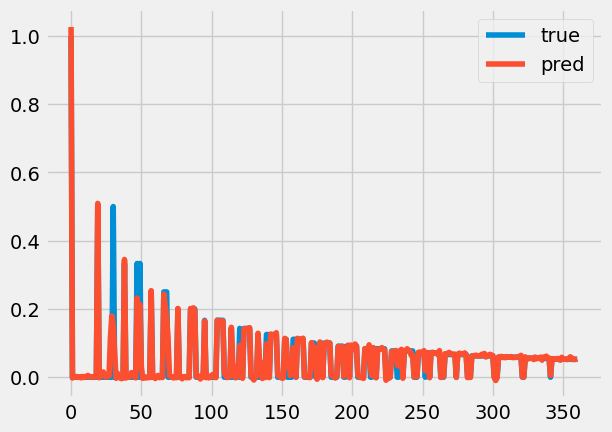

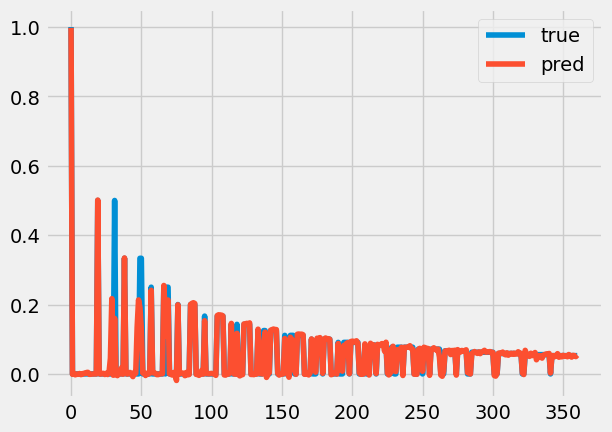

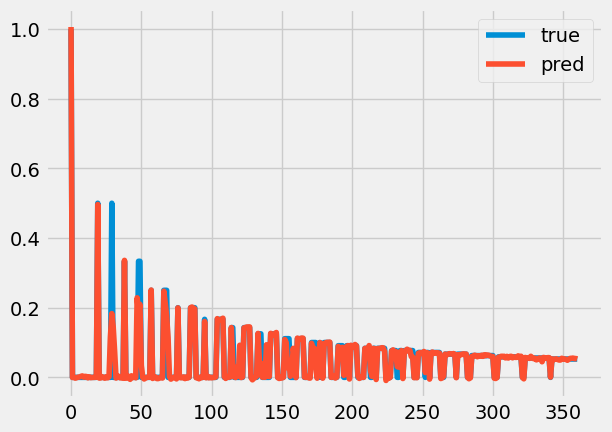

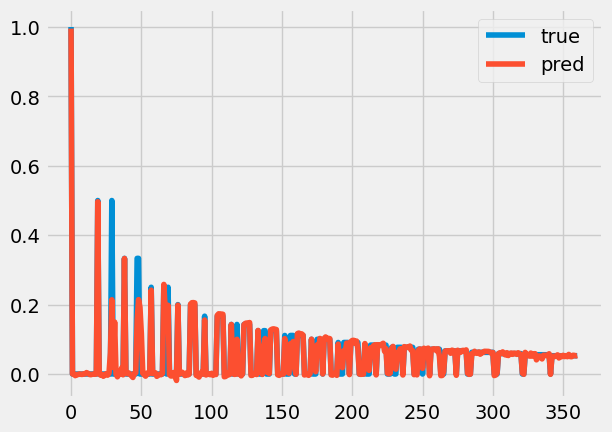

In [14]:
outputs = []
for human_id in range(10):
    for i in [1]:
        first_traj = human_to_trial_num_to_traj[human_id][i]

        first_traj = Variable(torch.Tensor(first_traj)).to(device=DEVICE)

        reconstructed = model(first_traj)

    #     print("reconstructed=", reconstructed)
    #     print("second_traj = ",second_traj)

        true = np.squeeze(np.squeeze(first_traj.detach().numpy(), 0), 0)
        pred = np.squeeze(np.squeeze(reconstructed.detach().numpy(), 0), 0)
        outputs.append(pred)

        plt.plot(range(len(true)), true)
        plt.plot(range(len(pred)), pred)
        plt.legend(['true', 'pred'])
        plt.show()
        plt.close()
    

In [15]:
# model.encoder(second_traj)

x_vals = []
y_vals = []
for human_id in human_to_trial_num_to_traj:
    print("human_id = ", human_id)
    for i in [1]:
        print("i = ", i)
        first_traj = human_to_trial_num_to_traj[human_id][i]


        first_traj = Variable(torch.Tensor(first_traj)).to(device=DEVICE)
#         second_traj = Variable(torch.Tensor(second_traj)).to(device=DEVICE)

    #     reconstructed = model(first_traj)
        latent_rep = model.encoder(first_traj)

    #     print("reconstructed=", reconstructed)
    #     print("second_traj = ",second_traj)

    #     true = np.squeeze(np.squeeze(second_traj.detach().numpy(), 0), 0)
        pred = np.squeeze(np.squeeze(latent_rep.detach().numpy(), 0), 0)
        print("pred = ", pred)

        x_vals.append(pred[0])
        y_vals.append(pred[1])
    

human_id =  0
i =  1
pred =  [-0.05044939 -2.4393816 ]
human_id =  1
i =  1
pred =  [0.06227818 0.14639771]
human_id =  2
i =  1
pred =  [-0.02952534 -2.3748803 ]
human_id =  3
i =  1
pred =  [ 0.14176784 -1.055476  ]
human_id =  4
i =  1
pred =  [ 0.23234975 -0.759051  ]
human_id =  5
i =  1
pred =  [-0.03496309 -2.419174  ]
human_id =  6
i =  1
pred =  [0.12466381 0.08804893]
human_id =  7
i =  1
pred =  [-0.33907232  0.6082327 ]
human_id =  8
i =  1
pred =  [0.06330676 0.14518516]
human_id =  9
i =  1
pred =  [-0.2681067   0.52717125]
human_id =  10
i =  1
pred =  [ 0.01042107 -2.1024065 ]
human_id =  11
i =  1
pred =  [-0.30075023  0.5646311 ]
human_id =  12
i =  1
pred =  [-0.06801374  0.28956795]
human_id =  13
i =  1
pred =  [-0.31352374  0.5785532 ]
human_id =  14
i =  1
pred =  [-0.2327578   0.48359382]
human_id =  15
i =  1
pred =  [0.01514038 0.19450766]
human_id =  16
i =  1
pred =  [ 0.19299185 -0.82495075]
human_id =  17
i =  1
pred =  [-0.05455753  0.27232626]
human_id =

pred =  [-0.21544567  0.4621194 ]
human_id =  207
i =  1
pred =  [ 0.17617857 -0.9275604 ]
human_id =  208
i =  1
pred =  [-0.26531202  0.52271575]
human_id =  209
i =  1
pred =  [-0.12362805  0.35362452]
human_id =  210
i =  1
pred =  [ 0.12144344 -1.2528794 ]
human_id =  211
i =  1
pred =  [-0.02641946 -2.2297165 ]
human_id =  212
i =  1
pred =  [-0.32267353  0.5899894 ]
human_id =  213
i =  1
pred =  [ 0.23237255 -0.74997866]
human_id =  214
i =  1
pred =  [-0.25392923  0.51055825]
human_id =  215
i =  1
pred =  [ 0.19334291 -0.83361876]
human_id =  216
i =  1
pred =  [-0.15455967  0.3909834 ]
human_id =  217
i =  1
pred =  [ 0.05734912 -1.8333352 ]
human_id =  218
i =  1
pred =  [ 0.19410577 -0.94990796]
human_id =  219
i =  1
pred =  [0.14519767 0.06415787]
human_id =  220
i =  1
pred =  [-0.2111342   0.46013784]
human_id =  221
i =  1
pred =  [ 0.20908788 -0.8677822 ]
human_id =  222
i =  1
pred =  [ 0.13301206 -1.2545145 ]
human_id =  223
i =  1
pred =  [-0.04998121  0.267071  ]

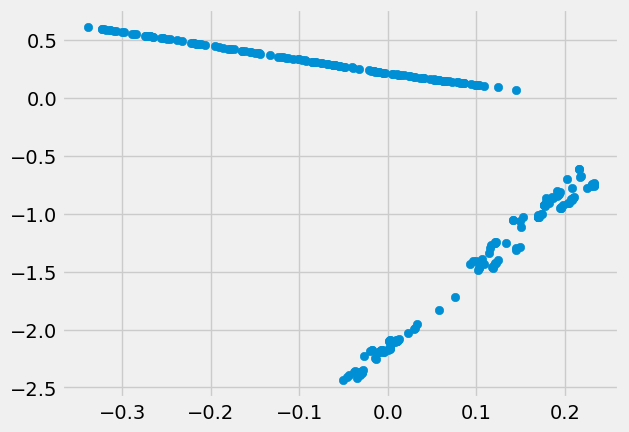

In [16]:
plt.scatter(x_vals, y_vals)
plt.show()

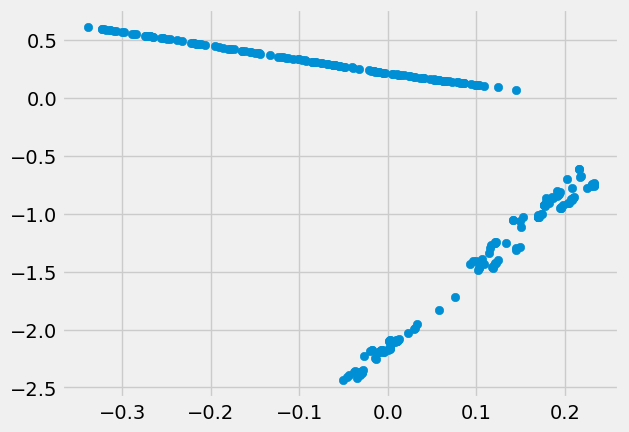

In [17]:
plt.scatter(x_vals, y_vals)
plt.show()

In [18]:
X = np.array([[x_vals[i], y_vals[i]] for i in range(len(x_vals))])

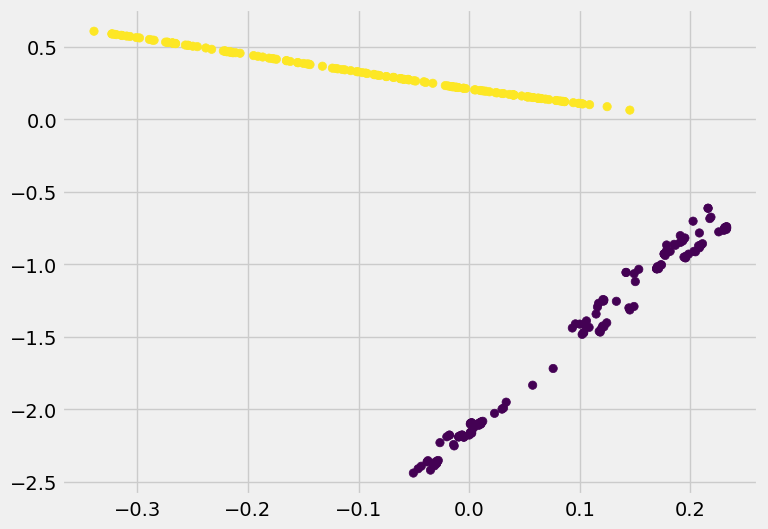

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling the data to normalize
model = KMeans(n_clusters=2).fit(X)

# Visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))
plt.show()

In [20]:
print("CLass 1 = ", np.count_nonzero(model.labels_))
print("CLass 2 = ", len(model.labels_) - np.count_nonzero(model.labels_))

CLass 1 =  151
CLass 2 =  149


In [21]:
len(human_to_trial_num_to_traj)

300

In [22]:
len(model.labels_)

300

In [23]:
labels = model.labels_.reshape((number_of_seqs_to_use))

In [24]:
labels

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], d

In [25]:
label_to_text ={0: 'salad-then-dressing', 1:'dressing-then-salad'}

In [26]:
for i in range(len(labels)):
    print(f"id: {i}, label = {labels[i]}, {label_to_text[labels[i]]}")

id: 0, label = 0, salad-then-dressing
id: 1, label = 1, dressing-then-salad
id: 2, label = 0, salad-then-dressing
id: 3, label = 0, salad-then-dressing
id: 4, label = 0, salad-then-dressing
id: 5, label = 0, salad-then-dressing
id: 6, label = 1, dressing-then-salad
id: 7, label = 1, dressing-then-salad
id: 8, label = 1, dressing-then-salad
id: 9, label = 1, dressing-then-salad
id: 10, label = 0, salad-then-dressing
id: 11, label = 1, dressing-then-salad
id: 12, label = 1, dressing-then-salad
id: 13, label = 1, dressing-then-salad
id: 14, label = 1, dressing-then-salad
id: 15, label = 1, dressing-then-salad
id: 16, label = 0, salad-then-dressing
id: 17, label = 1, dressing-then-salad
id: 18, label = 0, salad-then-dressing
id: 19, label = 1, dressing-then-salad
id: 20, label = 1, dressing-then-salad
id: 21, label = 0, salad-then-dressing
id: 22, label = 1, dressing-then-salad
id: 23, label = 1, dressing-then-salad
id: 24, label = 0, salad-then-dressing
id: 25, label = 0, salad-then-dress

# Silhouette Score Analysis

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [28]:
X = np.array([[x_vals[i], y_vals[i]] for i in range(len(x_vals))])
sil_scores = []
n_cluster_list = []
for num_cluster in range(2, 10):
    model = KMeans(n_clusters=num_cluster).fit(X)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_scores.append(silhouette_avg)
    n_cluster_list.append(num_cluster)
    

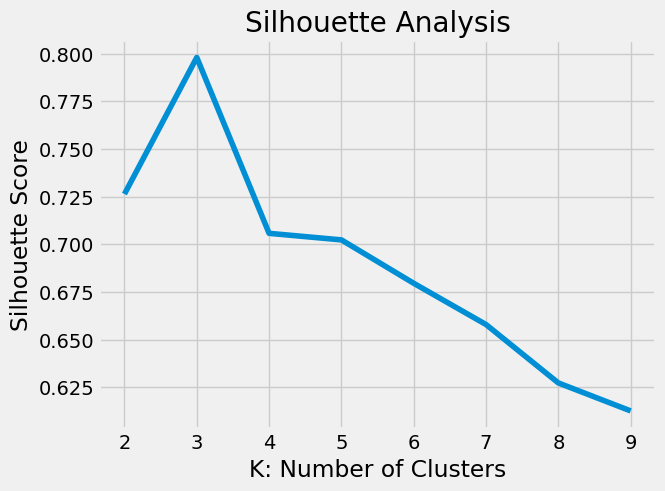

In [29]:
plt.plot(n_cluster_list, sil_scores)
plt.xlabel("K: Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

# Examine K=3

In [30]:
num_to_color = {0:'red', 1:'blue', 2:'green'}


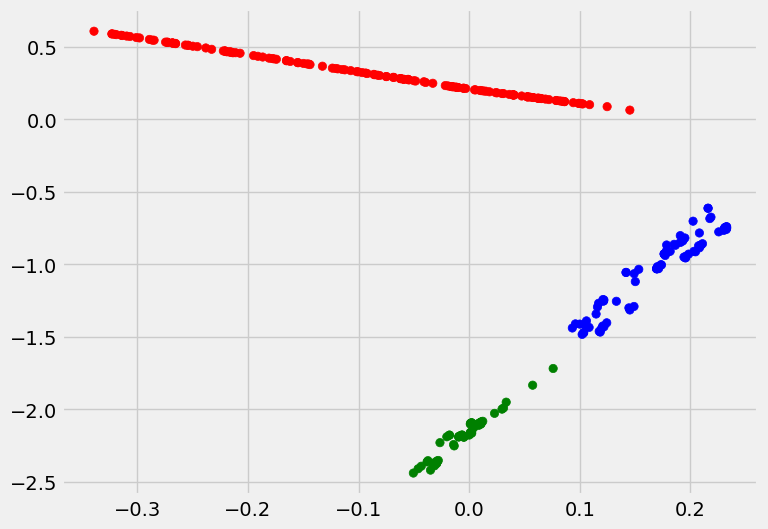

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling the data to normalize
K = 3
model = KMeans(n_clusters=K).fit(X)

# Visualize it:
plt.figure(figsize=(8, 6))
color_list = [num_to_color[c] for c in model.labels_.astype(float)]
# plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))
plt.scatter(X[:,0], X[:,1], c=color_list)
plt.show()

In [32]:
print("CLass 1 = ", list(model.labels_).count(0))
print("CLass 2 = ", list(model.labels_).count(1))
print("CLass 3 = ", list(model.labels_).count(2))

CLass 1 =  151
CLass 2 =  89
CLass 3 =  60


In [33]:
labels = model.labels_.reshape((number_of_seqs_to_use))

In [34]:
label_to_text ={1: 'salad-then-dressing', 0:'dressing-then-salad', 2:'idk'}

In [35]:
for i in range(len(labels)):
    print(f"id: {i}, label = {labels[i]}, {label_to_text[labels[i]]}")

id: 0, label = 2, idk
id: 1, label = 0, dressing-then-salad
id: 2, label = 2, idk
id: 3, label = 1, salad-then-dressing
id: 4, label = 1, salad-then-dressing
id: 5, label = 2, idk
id: 6, label = 0, dressing-then-salad
id: 7, label = 0, dressing-then-salad
id: 8, label = 0, dressing-then-salad
id: 9, label = 0, dressing-then-salad
id: 10, label = 2, idk
id: 11, label = 0, dressing-then-salad
id: 12, label = 0, dressing-then-salad
id: 13, label = 0, dressing-then-salad
id: 14, label = 0, dressing-then-salad
id: 15, label = 0, dressing-then-salad
id: 16, label = 1, salad-then-dressing
id: 17, label = 0, dressing-then-salad
id: 18, label = 2, idk
id: 19, label = 0, dressing-then-salad
id: 20, label = 0, dressing-then-salad
id: 21, label = 2, idk
id: 22, label = 0, dressing-then-salad
id: 23, label = 0, dressing-then-salad
id: 24, label = 2, idk
id: 25, label = 2, idk
id: 26, label = 0, dressing-then-salad
id: 27, label = 1, salad-then-dressing
id: 28, label = 0, dressing-then-salad
id: 29,

# Train Aggregate Predictor

In [36]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable 

In [84]:

def create_dataset(stepsize, train_percent, check_index):
    trainX = []
    trainY = []

    for human_id in range(int(number_of_seqs_to_use*train_percent)):
        trial_id  = 1

        if check_index is not None and labels[human_id] != check_index:
            continue



        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]

        for i in range(len(seq)-stepsize):
            moving_window_x = []
            moving_window_y = []

            for j in range(stepsize):
                annot_idx = annot_to_num[seq[i+j]]
    #             current_state[annot_idx] = current_state[annot_idx] + 1
                current_state = np.zeros(number_of_annots) # comment out for state

                current_state[annot_idx] = 1

    #             normalized_current_state = [elem/sum(current_state) for elem in current_state]

                normalized_current_state = [elem/sum(current_state) for elem in current_state]

    #             print("normalized_current_state", normalized_current_state)
                moving_window_x.extend(normalized_current_state)

            annot_idx = annot_to_num[seq[i+stepsize]]
    #         current_state[annot_idx] = current_state[annot_idx] + 1
            current_state[annot_idx] = 1

            normalized_current_state = [elem/sum(current_state) for elem in current_state]
    #         normalized_current_state = [elem for elem in current_state]
    #         moving_window_y.extend(normalized_current_state)

            moving_window_y.append(annot_idx)

            trainX.append(moving_window_x)
            trainY.append(moving_window_y)


    trainX = np.array(trainX)
    trainY = np.array(trainY)

    trainY = np.squeeze(trainY,1)
    trainY.shape

    X_train_tensors = Variable(torch.Tensor(trainX))

    y_train_tensors = Variable(torch.Tensor(trainY))

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    # X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

    return X_train_tensors_final, y_train_tensors

In [70]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 =  nn.Linear(128, 256) #fully connected 1
        self.fc_3 =  nn.Linear(256, 64) #fully connected 1
        self.fc = nn.Linear(64, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(hn) #first Dense
#         out = self.relu(out) #relu
        out = self.fc_2(out) #first Dense
        out = self.fc_3(out) #first Dense
        out = self.fc(out) #Final Output
#         out = self.softmax(out)
        return out

In [85]:
def compute_train_accuracy(stepsize, train_percent, check_index, lstm1):
    count_correct = 0
    total = 0
    count_close = 0
    train_true_list, train_pred_list = [], []

    conf_mat_dict = {}
    for i in range(number_of_annots):
        for j in range(number_of_annots):
            conf_mat_dict[(i,j)] = []

    inaccuracy = []

    train_indices = np.random.choice(range(number_of_seqs_to_use), size=int(number_of_seqs_to_use*train_percent), replace=False)
    for human_id in train_indices:
        trial_id  = 1

        if check_index is not None and labels[human_id] != check_index:
            continue

        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]

        for i in range(len(seq)-stepsize):
            human_id_trainX = []
            human_id_trainY = []


            moving_window_x = []
            moving_window_y = []


            for j in range(stepsize):
                annot_idx = annot_to_num[seq[i+j]]
    #             current_state[annot_idx] = current_state[annot_idx] + 1

                current_state = np.zeros(number_of_annots)
                current_state[annot_idx] = 1

                normalized_current_state = [elem/sum(current_state) for elem in current_state]

    #             print("normalized_current_state", normalized_current_state)
                moving_window_x.extend(normalized_current_state)

            annot_idx = annot_to_num[seq[i+stepsize]]
    #         current_state[annot_idx] = current_state[annot_idx] + 1
            current_state[annot_idx] = 1
            normalized_current_state = [elem for elem in current_state]
    #         normalized_current_state = [elem for elem in current_state]
            moving_window_y.append(annot_idx)

            human_id_trainX.append(moving_window_x)
            human_id_trainY.append(moving_window_y)


            human_id_trainX = np.array(human_id_trainX)
            human_id_trainY = np.array(human_id_trainY)

            X_train_tensors = Variable(torch.Tensor(human_id_trainX))
            y_train_tensors = Variable(torch.Tensor(human_id_trainY))


            X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    #         print("X_train_tensors_final", X_train_tensors_final)
            outputs = lstm1.forward(X_train_tensors_final)
            outputs = outputs.detach().numpy()[0]

    #         min_outputs = min(outputs)
    #         if min_outputs < 0:
    #             outputs = [elem - min_outputs for elem in outputs]
    #         outputs /= sum(outputs)
            outputs = softmax(outputs)
            pred_idx = np.argmax(outputs)

            true_idx = int(y_train_tensors.detach().numpy()[0][0])

            train_true_list.append(true_idx)
            train_pred_list.append(pred_idx)
    #         outputs = nn.softmax(outputs)
            outputs_max = np.max(outputs)
            true_idx_val = outputs[true_idx]
    #         if outputs_max != true_idx_val:
    #             print(f"outputs_max = {outputs_max}, true_idx_val = {true_idx_val}")
            largest_dist = np.max(outputs)
            inaccuracy.append((outputs_max - true_idx_val))


            for j in range(len(outputs)):
                conf_mat_dict[(true_idx,j)].append(outputs[j])


            if abs(outputs_max - true_idx_val) < 0.1:
                count_close += 1
    #         outputs = [np.round(elem,2) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         num_nonzero = np.count_nonzero(outputs)
    #         outputs = [np.round(elem*num_nonzero,0) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         print("num_nonzero", num_nonzero)
    #         print("pred_idx", pred_idx)
    #         print("true_idx", true_idx)
    #         print(outputs == y_train_tensors.detach().numpy()[0])
            if (pred_idx == true_idx):
                count_correct += 1
    #         else:
    #             print()
    #             print("outputs", [np.round(x, 2) for x in outputs])
    #             print(f"outputs_max = {outputs_max}, true_idx_val = {true_idx_val}")
            total += 1
    #         break
    #     break

    print("train accuracy =", count_correct/total)
    print("close but not quite: train accuracy =", count_close/total)
    print("Inaccuracy = ", np.mean(inaccuracy))
    print("Sum Inaccuracy = ", sum(inaccuracy))
    
    conf_mat = np.zeros((number_of_annots, number_of_annots))

    for i in range(number_of_annots):
        for j in range(number_of_annots):
            if len(conf_mat_dict[(i,j)])!=0:
                conf_mat[i][j] = np.sum(conf_mat_dict[(i,j)])

    for i in range(number_of_annots):
        sum_across_row = sum(conf_mat[i,:])
        for j in range(number_of_annots):
            if sum_across_row!=0:
                conf_mat[i][j] = conf_mat[i][j]/sum_across_row

    fig, ax = plt.subplots(figsize=(10,10))


    ax.matshow(conf_mat, cmap=plt.cm.Blues)


    for i in np.arange(number_of_annots):
        for j in np.arange(number_of_annots):
            c = conf_mat[j,i]*100
            ax.text(i, j, str(np.round(c,1)), va='center', ha='center')

    x = np.arange(number_of_annots)

    plt.xticks(x, all_annotations, rotation='vertical')
    plt.yticks(x, all_annotations, rotation='horizontal')
    plt.title("Train Confusion Matrix")
    plt.show()
    plt.close()


In [86]:
def compute_test_accuracy(stepsize, train_percent, check_index, lstm1):

    count_correct = 0
    total = 0
    count_close = 0
    test_true_list = []
    test_pred_list = []
    inaccuracy = []
    conf_mat_dict = {}
    for i in range(number_of_annots):
        for j in range(number_of_annots):
            conf_mat_dict[(i,j)] = []

    # test_indices = np.random.choice(range(number_of_seqs_to_use), size=int(number_of_seqs_to_use*train_percent), replace=False)

    # for human_id in range(int(100*train_percent), 100):
    for human_id in range(number_of_seqs_to_use):
    #     print(f"human_id: {human_id}")
        if human_id in train_indices:
            continue
        trial_id  = 1

        if check_index is not None and labels[human_id] != check_index:
            continue

        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]

        for i in range(len(seq)-stepsize):
            human_id_trainX = []
            human_id_trainY = []


            moving_window_x = []
            moving_window_y = []

            moving_window_x_annot_text = []
            moving_window_y_annot_text = []


            for j in range(stepsize):
                annot_idx = annot_to_num[seq[i+j]]
    #             current_state[annot_idx] = current_state[annot_idx] + 1
                current_state = np.zeros(number_of_annots)

                current_state[annot_idx] = 1

                normalized_current_state = [elem/sum(current_state) for elem in current_state]

    #             print("normalized_current_state", normalized_current_state)
                moving_window_x.extend(normalized_current_state)
                moving_window_x_annot_text.append(annot_idx)

            annot_idx = annot_to_num[seq[i+stepsize]]
            moving_window_y_annot_text.append(annot_idx)
    #         current_state[annot_idx] = current_state[annot_idx] + 1
            current_state[annot_idx] = 1
            normalized_current_state = [elem for elem in current_state]
    #         normalized_current_state = [elem for elem in current_state]
            moving_window_y.append(annot_idx)

            human_id_trainX.append(moving_window_x)
            human_id_trainY.append(moving_window_y)


            human_id_trainX = np.array(human_id_trainX)
            human_id_trainY = np.array(human_id_trainY)


            X_train_tensors = Variable(torch.Tensor(human_id_trainX))
            y_train_tensors = Variable(torch.Tensor(human_id_trainY))
    #         print("Input X:", [num_to_annot[c] for c in moving_window_x_annot_text])

            X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    #         print("X_train_tensors_final", X_train_tensors_final)
            outputs = lstm1.forward(X_train_tensors_final)
            outputs = outputs.detach().numpy()[0]

    #         min_outputs = min(outputs)
    #         if min_outputs < 0:
    #             outputs = [elem - min_outputs for elem in outputs]
    #         outputs /= sum(outputs)
    #         print("outputs", outputs)

            outputs = softmax(outputs)
            pred_idx = np.argmax(outputs)
            true_idx = int(y_train_tensors.detach().numpy()[0][0])

            for j in range(len(outputs)):
                conf_mat_dict[(true_idx,j)].append(outputs[j])

    #         print(f"True Y: {true_idx}, {num_to_annot[true_idx]}, {outputs[true_idx]}" )
    #         print(f"Pred Y: {pred_idx}, {num_to_annot[pred_idx]}, {outputs[pred_idx]}" )

    #         print()

            test_true_list.append(true_idx)
            test_pred_list.append(pred_idx)

            outputs_max = np.max(outputs)
            true_idx_val = outputs[true_idx]
            max_dist = np.max(outputs)
            inaccuracy.append((outputs_max - true_idx_val))

            if abs(outputs_max - true_idx_val) < 0.1:
                count_close += 1
    #         outputs = [np.round(elem,2) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         num_nonzero = np.count_nonzero(outputs)
    #         outputs = [np.round(elem*num_nonzero,0) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         print("num_nonzero", num_nonzero)
    #         print("pred_idx", pred_idx)
    #         print("true_idx", true_idx)
    #         print(outputs == y_train_tensors.detach().numpy()[0])
            if (pred_idx == true_idx):
                count_correct += 1
            else:
                print()
                print("outputs", [np.round(x, 2) for x in outputs])
                print(f"outputs_max = {outputs_max}, true_idx_val = {true_idx_val}")
                print("inaccuracy ",outputs_max - true_idx_val)
                print()
            total += 1
    #         break
    #     break

    print("test accuracy =", count_correct/total)
    print("close but not quite: test accuracy =", count_close/total)
    print("Inaccuracy = ", np.mean(inaccuracy))
    print("Sum Inaccuracy = ", sum(inaccuracy))


    conf_mat = np.zeros((number_of_annots, number_of_annots))

    for i in range(number_of_annots):
        for j in range(number_of_annots):
            if len(conf_mat_dict[(i,j)])!=0:
                conf_mat[i][j] = np.sum(conf_mat_dict[(i,j)])

    for i in range(number_of_annots):
        sum_across_row = sum(conf_mat[i,:])
        for j in range(number_of_annots):
            if sum_across_row!=0:
                conf_mat[i][j] = conf_mat[i][j]/sum_across_row

    fig, ax = plt.subplots(figsize=(10,10))


    ax.matshow(conf_mat, cmap=plt.cm.Blues)



    for i in np.arange(number_of_annots):
        for j in np.arange(number_of_annots):
            c = conf_mat[j,i]*100
            ax.text(i, j, str(np.round(c,1)), va='center', ha='center')

    x = np.arange(number_of_annots)

    plt.xticks(x, all_annotations, rotation='vertical')
    plt.yticks(x, all_annotations, rotation='horizontal')
    plt.title("Test Confusion Matrix")
    plt.show()
    plt.close()

In [124]:
def train_lstm(stepsize, train_percent, check_index, num_classes, input_size, hidden_size, num_layers):

    X_train_tensors_final, y_train_tensors = create_dataset(stepsize, train_percent, check_index)

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
    # criterion = torch.nn.MSELoss()    # mean-squared error for regression
    criterion = torch.nn.CrossEntropyLoss()
    # criterion = torch.nn.KLDivLoss(reduction="batchmean")
    # criterion = torch.nn.BCELoss()

    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
    losses = []
    num_epochs = 5000
    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
    #     print("outputs", outputs)
    #     print("y_train_tensors", y_train_tensors)
        loss = criterion(outputs, y_train_tensors.long())
    #     loss = criterion(outputs, y_train_tensors)
        losses.append(loss.detach().numpy())

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        if epoch % 1000 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
            
    plt.plot(range(len(losses)), losses)
    plt.show()
    plt.close()
    
    compute_train_accuracy(stepsize, train_percent, check_index, lstm1)
    compute_test_accuracy(stepsize, train_percent, check_index, lstm1)
    
    
    
    return lstm1

# Run for all groups

In [125]:
stepsize = 5
train_percent = 0.8
check_index = 2

In [126]:

num_epochs = 40000 #1000 epochs
learning_rate = 0.0001 #0.001 lr


input_size = 95 #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 19 #number of output classes 


Epoch: 0, loss: 2.95288
Epoch: 1000, loss: 1.31464
Epoch: 2000, loss: 0.88375
Epoch: 3000, loss: 0.76189
Epoch: 4000, loss: 0.69459


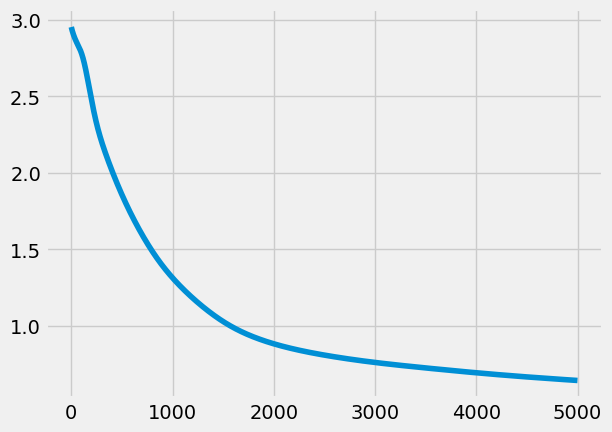

train accuracy = 0.736904761904762
close but not quite: train accuracy = 0.7791666666666667
Inaccuracy =  0.08623593
Sum Inaccuracy =  289.7527832388878


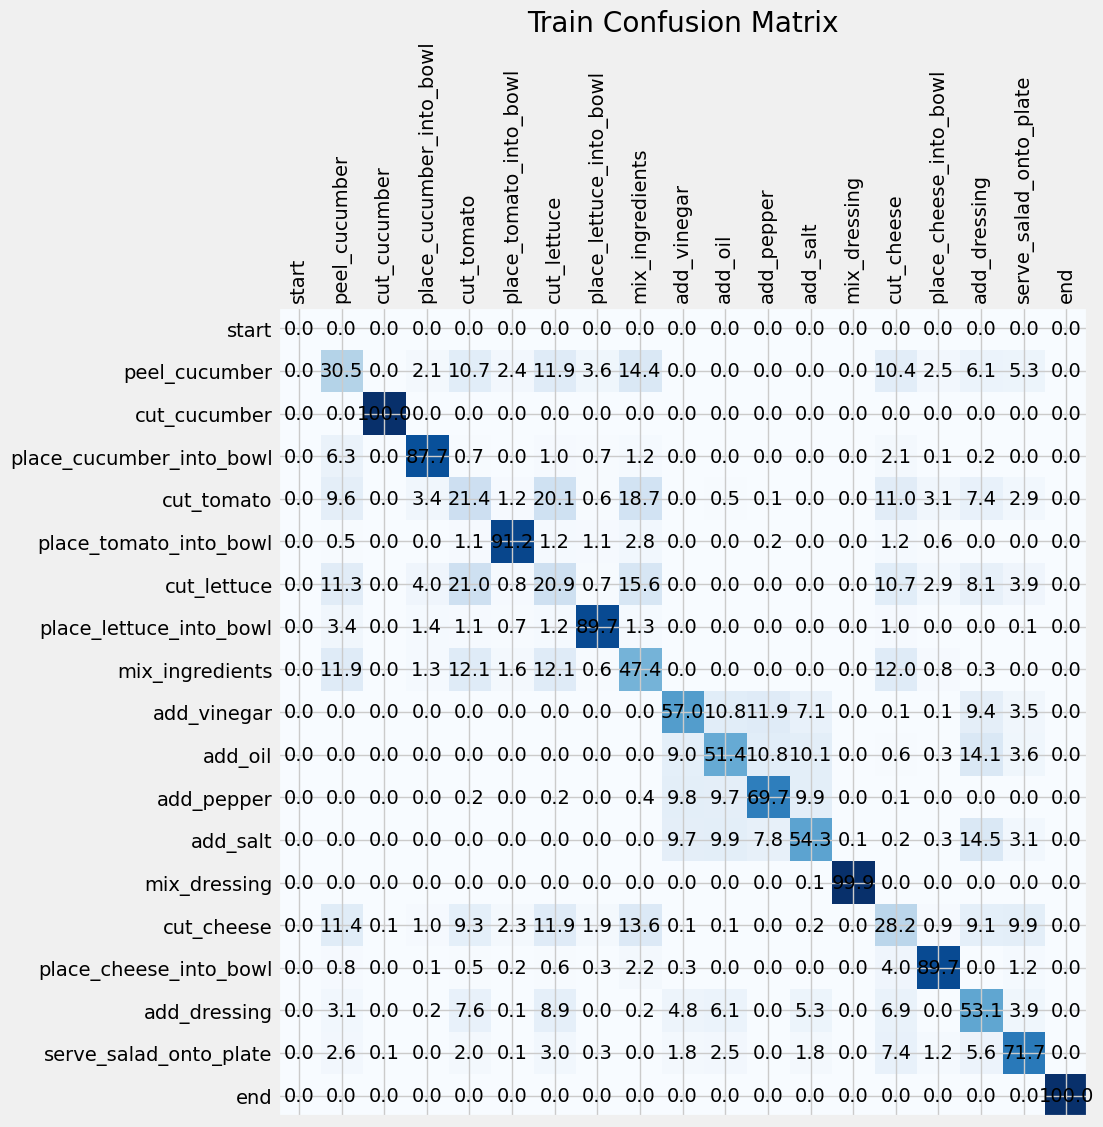


outputs [0.0, 0.07, 0.0, 0.0, 0.31, 0.02, 0.28, 0.03, 0.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.3080495595932007, true_idx_val = 0.2849574089050293
inaccuracy  0.02309215


outputs [0.0, 0.52, 0.0, 0.08, 0.03, 0.0, 0.04, 0.01, 0.31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5184897184371948, true_idx_val = 0.31355994939804077
inaccuracy  0.20492977


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.23, 0.0, 0.18, 0.0, 0.01, 0.0, 0.45, 0.05, 0.0]
outputs_max = 0.4495648145675659, true_idx_val = 0.23049722611904144
inaccuracy  0.21906759


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.12, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.7960378527641296, true_idx_val = 0.08406676352024078
inaccuracy  0.7119711


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31, 0.0, 0.67, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02]
outputs_max = 0.6678720116615295, true_idx_val = 0.3085663616657257
inaccuracy  


outputs [0.0, 0.0, 0.0, 0.0, 0.04, 0.44, 0.04, 0.0, 0.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.14, 0.0, 0.0, 0.0]
outputs_max = 0.4393492341041565, true_idx_val = 0.03972754627466202
inaccuracy  0.3996217


outputs [0.0, 0.02, 0.0, 0.0, 0.12, 0.04, 0.14, 0.0, 0.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.01, 0.0, 0.0, 0.0]
outputs_max = 0.4379434883594513, true_idx_val = 0.012589524500072002
inaccuracy  0.42535397


outputs [0.0, 0.05, 0.0, 0.0, 0.07, 0.0, 0.1, 0.0, 0.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38, 0.06, 0.0, 0.0, 0.0]
outputs_max = 0.3835233747959137, true_idx_val = 0.0041003660298883915
inaccuracy  0.37942302


outputs [0.0, 0.07, 0.0, 0.0, 0.46, 0.0, 0.37, 0.03, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0]
outputs_max = 0.4584880471229553, true_idx_val = 0.37326037883758545
inaccuracy  0.08522767


outputs [0.0, 0.01, 0.0, 0.0, 0.32, 0.01, 0.23, 0.0, 0.39, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0]
outputs_max = 0.38608407974243164, true_idx_val = 0.3211880028247833
i


outputs [0.0, 0.04, 0.0, 0.0, 0.03, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21, 0.0, 0.0, 0.67, 0.0]
outputs_max = 0.6655752062797546, true_idx_val = 0.044275913387537
inaccuracy  0.62129927


outputs [0.0, 0.2, 0.0, 0.51, 0.04, 0.0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5069352388381958, true_idx_val = 0.07521852850914001
inaccuracy  0.4317167


outputs [0.0, 0.55, 0.0, 0.14, 0.11, 0.0, 0.14, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.55076664686203, true_idx_val = 0.14042706787586212
inaccuracy  0.4103396


outputs [0.0, 0.06, 0.0, 0.0, 0.11, 0.01, 0.14, 0.0, 0.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31, 0.01, 0.0, 0.0, 0.0]
outputs_max = 0.3713287115097046, true_idx_val = 0.30635687708854675
inaccuracy  0.064971834


outputs [0.0, 0.01, 0.0, 0.0, 0.11, 0.49, 0.11, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.49367356300354004, true_idx_val = 0.10600671172142029
inaccuracy


outputs [0.0, 0.04, 0.0, 0.0, 0.04, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.8, 0.0]
outputs_max = 0.7979907393455505, true_idx_val = 0.05960870161652565
inaccuracy  0.73838204


outputs [0.0, 0.17, 0.0, 0.0, 0.25, 0.0, 0.31, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.31406155228614807, true_idx_val = 0.24265506863594055
inaccuracy  0.07140648


outputs [0.0, 0.23, 0.0, 0.13, 0.35, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0]
outputs_max = 0.34846141934394836, true_idx_val = 0.23252946138381958
inaccuracy  0.11593196


outputs [0.0, 0.01, 0.0, 0.0, 0.24, 0.01, 0.2, 0.0, 0.51, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.01, 0.0, 0.0]
outputs_max = 0.5096938014030457, true_idx_val = 0.2413162887096405
inaccuracy  0.2683775


outputs [0.0, 0.05, 0.0, 0.0, 0.13, 0.01, 0.16, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.01, 0.0, 0.0, 0.0]
outputs_max = 0.3307642638683319, true_idx_val = 0.31793761253356934
inaccur

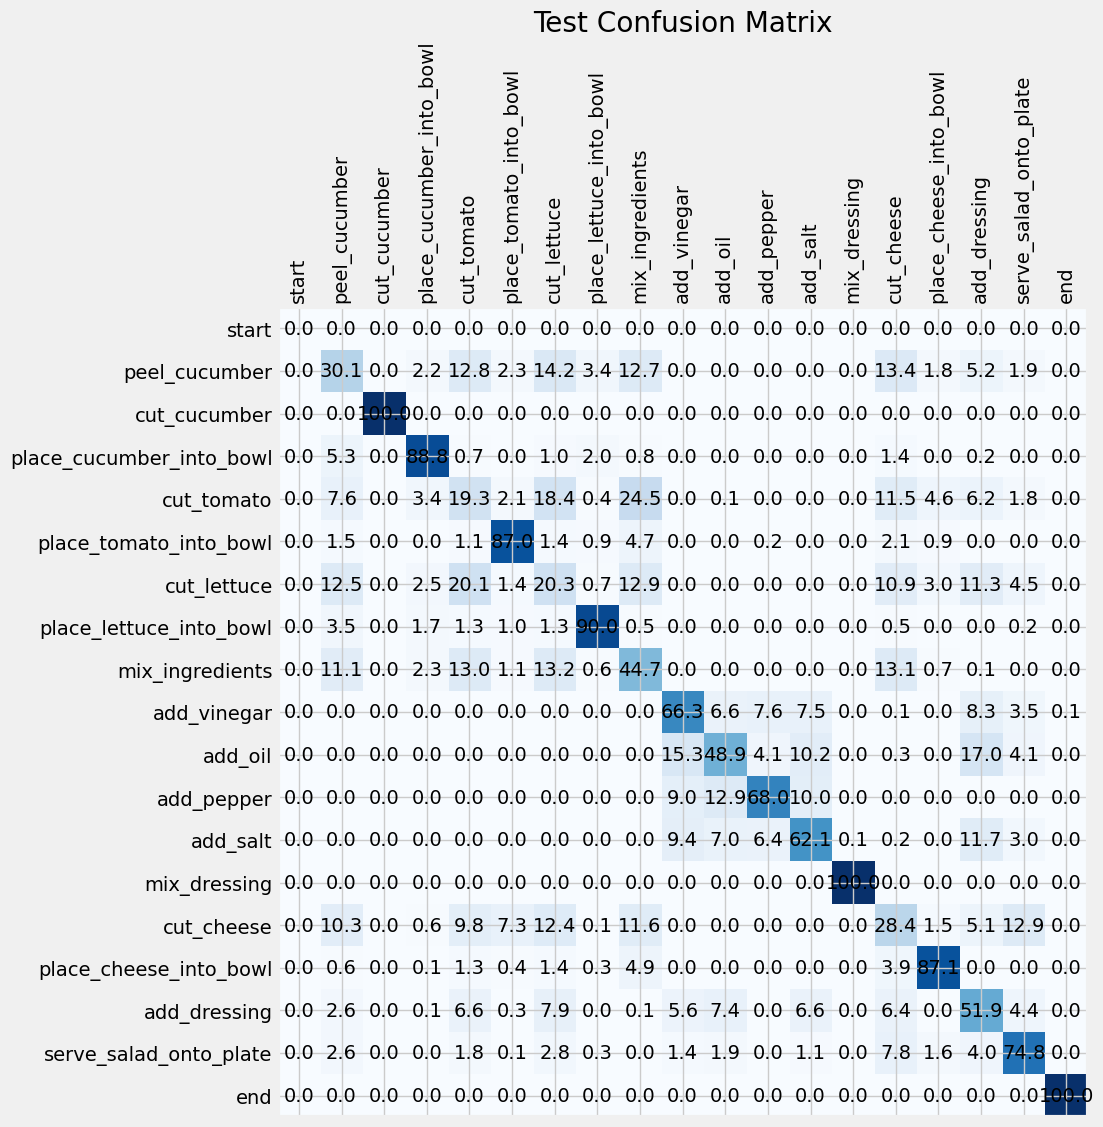

Epoch: 0, loss: 2.94530
Epoch: 1000, loss: 0.95469
Epoch: 2000, loss: 0.72147
Epoch: 3000, loss: 0.61172
Epoch: 4000, loss: 0.52733


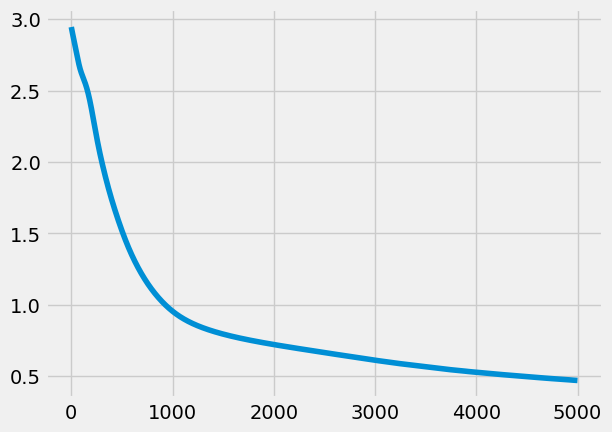

train accuracy = 0.7822299651567944
close but not quite: train accuracy = 0.8182346109175378
Inaccuracy =  0.06740474
Sum Inaccuracy =  116.07095973193645


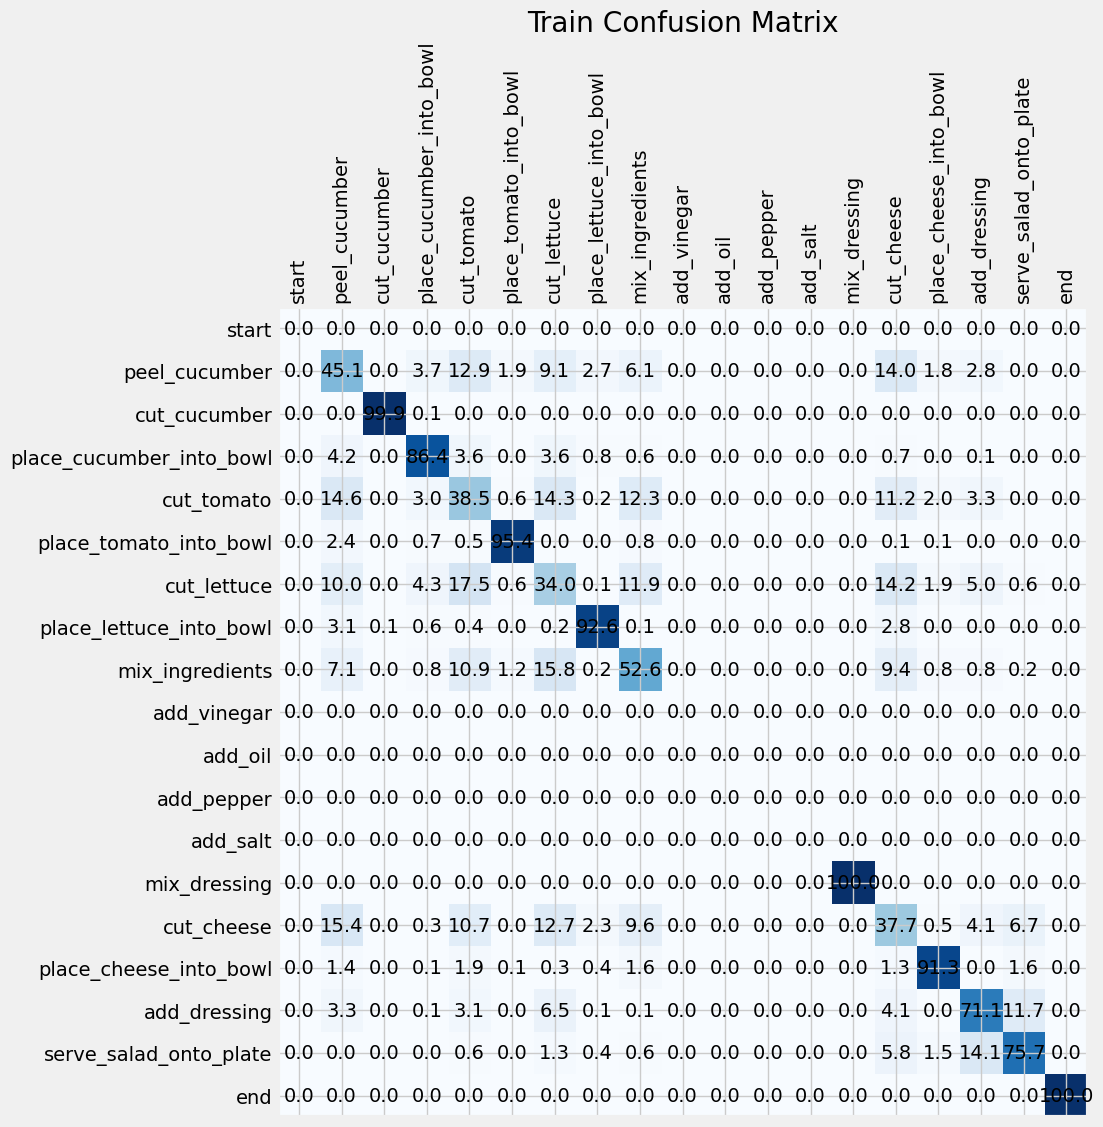


outputs [0.0, 0.15, 0.0, 0.0, 0.06, 0.0, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26, 0.0, 0.17, 0.0, 0.0]
outputs_max = 0.35540008544921875, true_idx_val = 0.15019768476486206
inaccuracy  0.2052024


outputs [0.0, 0.0, 0.0, 0.4, 0.2, 0.0, 0.38, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0]
outputs_max = 0.39593666791915894, true_idx_val = 0.19503848254680634
inaccuracy  0.20089819


outputs [0.0, 0.24, 0.0, 0.38, 0.0, 0.0, 0.35, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0]
outputs_max = 0.38233986496925354, true_idx_val = 0.3518962562084198
inaccuracy  0.030443609


outputs [0.0, 0.08, 0.01, 0.04, 0.0, 0.0, 0.0, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.8725563287734985, true_idx_val = 0.039417944848537445
inaccuracy  0.8331384


outputs [0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5968852639198303, true_idx_val = 0.1602984219789505
inaccuracy  0.4


outputs [0.0, 0.0, 0.0, 0.0, 0.32, 0.04, 0.03, 0.0, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.08, 0.0, 0.0, 0.0]
outputs_max = 0.465213805437088, true_idx_val = 0.31772059202194214
inaccuracy  0.14749321


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.6911464929580688, true_idx_val = 0.29980820417404175
inaccuracy  0.3913383


outputs [0.0, 0.7, 0.0, 0.03, 0.01, 0.0, 0.15, 0.0, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.6997723579406738, true_idx_val = 0.08789973706007004
inaccuracy  0.6118726


outputs [0.0, 0.47, 0.0, 0.0, 0.28, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.47009509801864624, true_idx_val = 0.28475749492645264
inaccuracy  0.1853376


outputs [0.0, 0.16, 0.0, 0.14, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.6963701248168945, true_idx_val = 0.16184784471988678
inaccuracy  0.5345

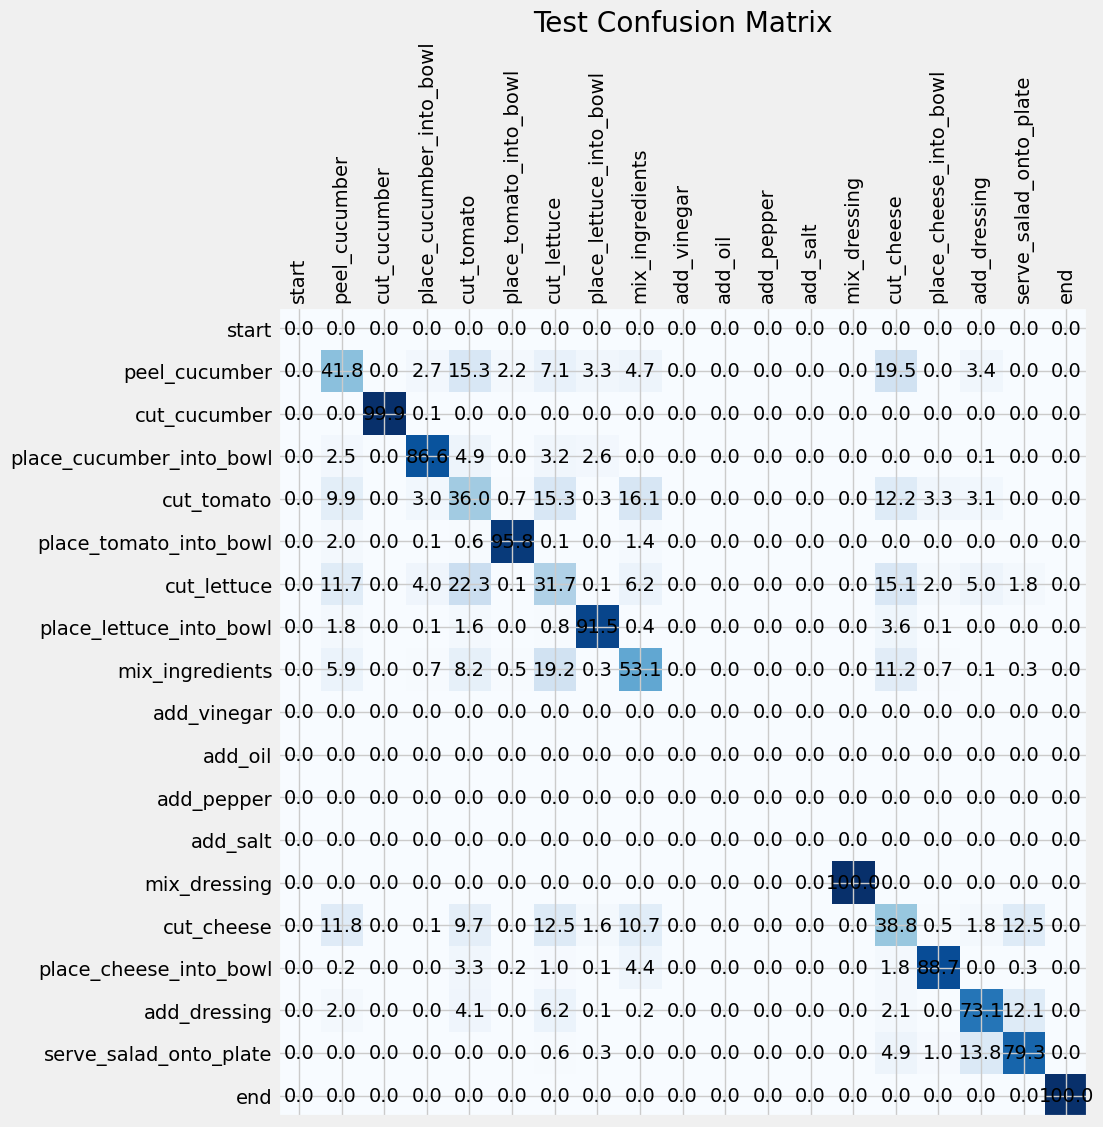

Epoch: 0, loss: 2.92538
Epoch: 1000, loss: 0.89486
Epoch: 2000, loss: 0.57115
Epoch: 3000, loss: 0.42735
Epoch: 4000, loss: 0.33573


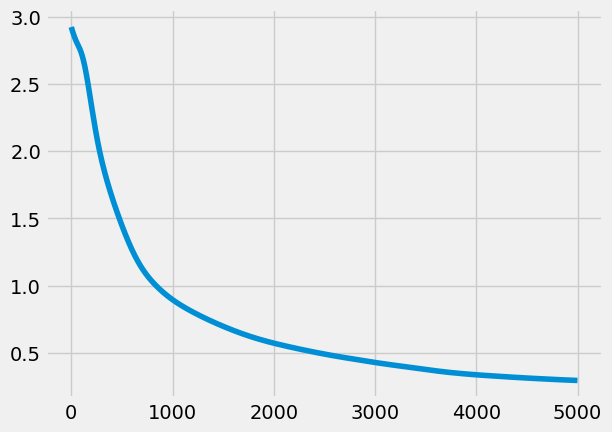

train accuracy = 0.8454157782515992
close but not quite: train accuracy = 0.8603411513859275
Inaccuracy =  0.056585435
Sum Inaccuracy =  53.07713641226292


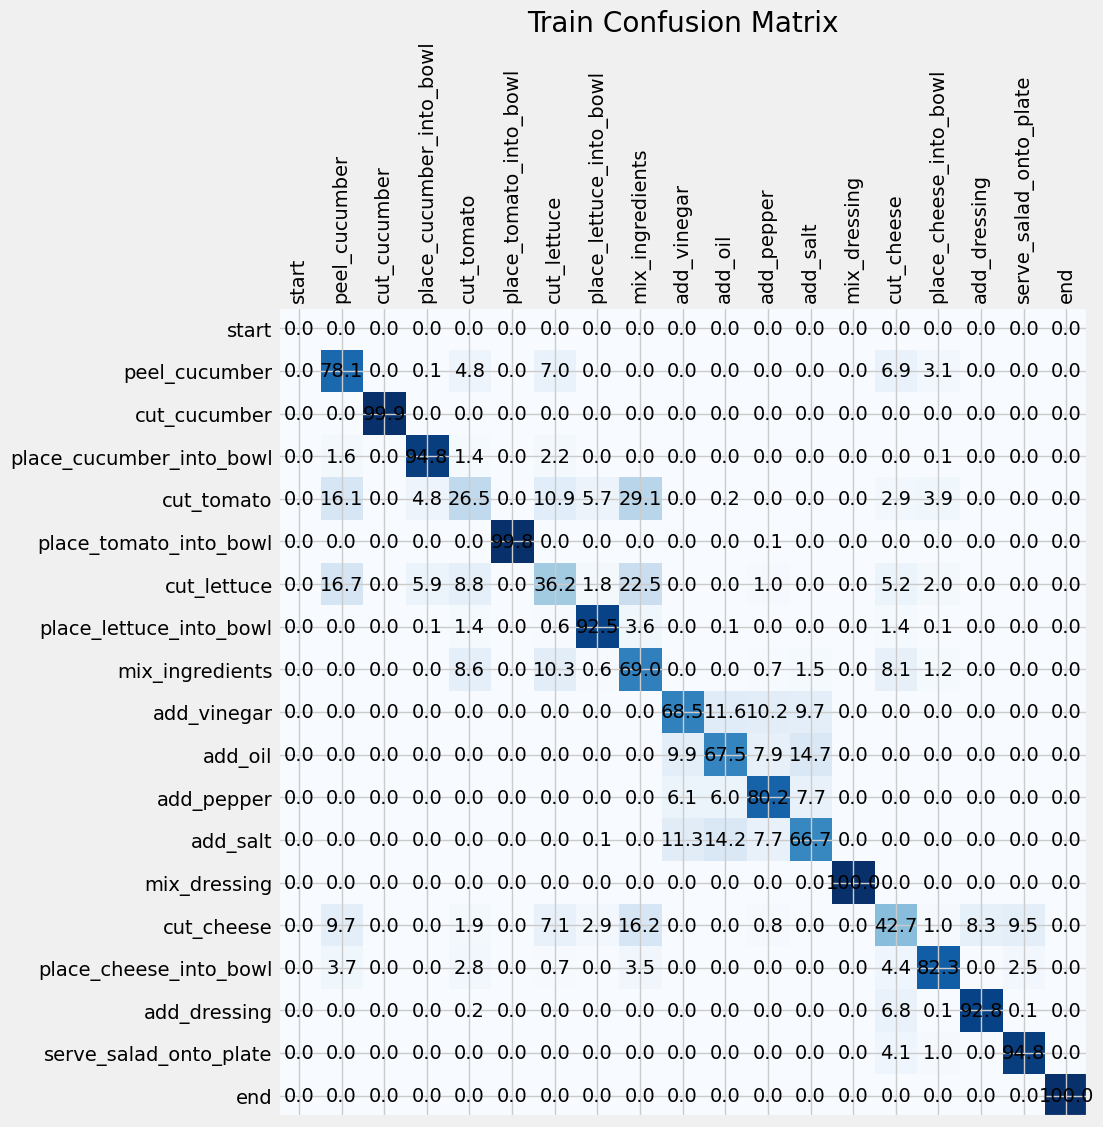


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.56, 0.27, 0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5601968765258789, true_idx_val = 0.2730952501296997
inaccuracy  0.28710163


outputs [0.0, 0.48, 0.0, 0.0, 0.0, 0.0, 0.52, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5169188976287842, true_idx_val = 0.48212477564811707
inaccuracy  0.034794122


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.0, 0.46, 0.0, 0.0, 0.05, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.45908495783805847, true_idx_val = 0.32673054933547974
inaccuracy  0.13235441


outputs [0.0, 0.0, 0.0, 0.0, 0.28, 0.0, 0.26, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.4640796482563019, true_idx_val = 0.2751227915287018
inaccuracy  0.18895686


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49, 0.27, 0.0, 0.23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.4938034117221832, true_idx_val = 0.23402447998523712
inaccuracy  0.25977

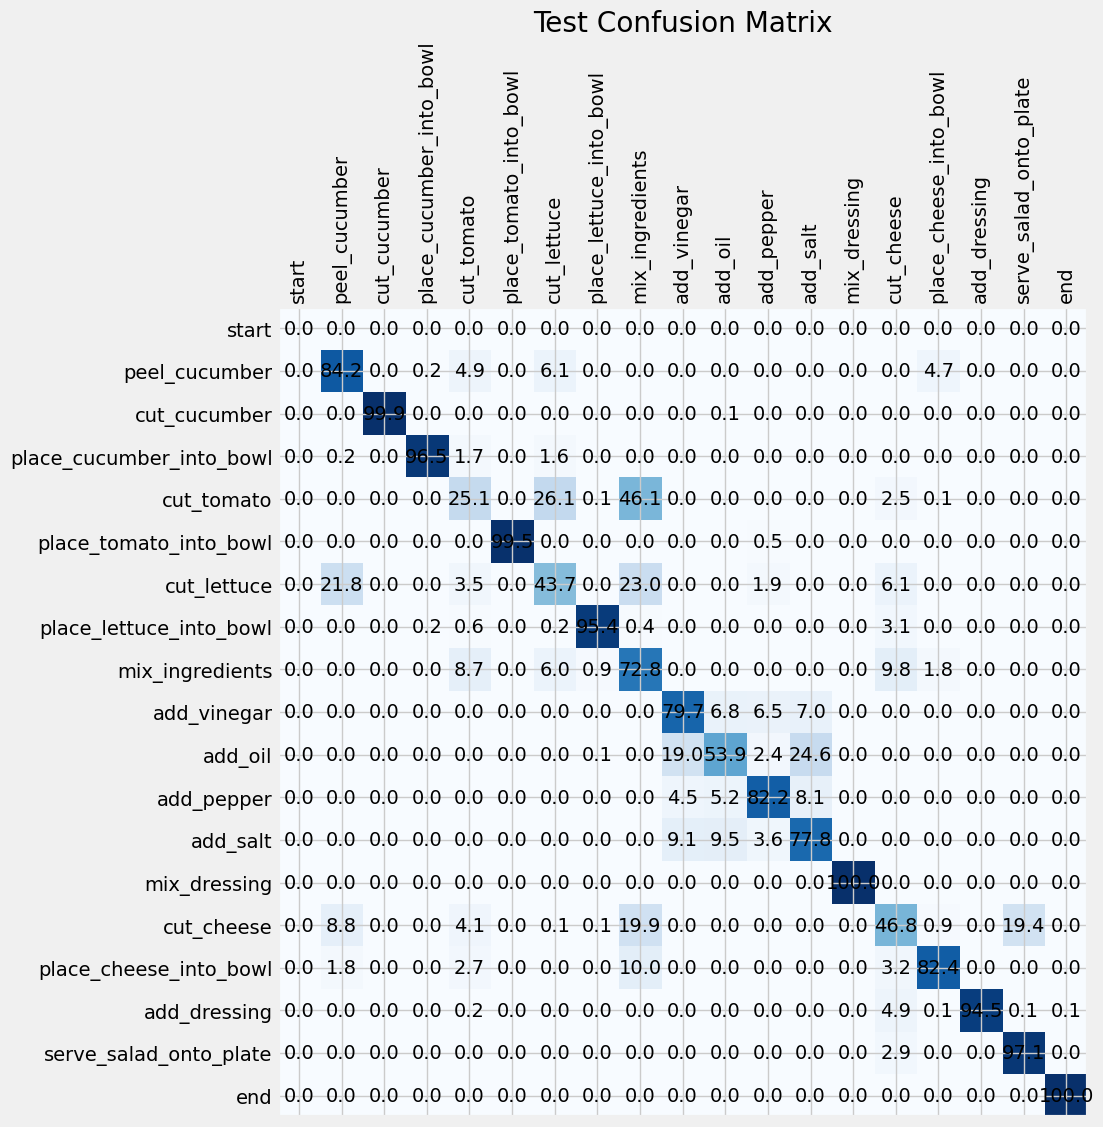

Epoch: 0, loss: 2.95334
Epoch: 1000, loss: 0.70244
Epoch: 2000, loss: 0.31849
Epoch: 3000, loss: 0.23386
Epoch: 4000, loss: 0.22625


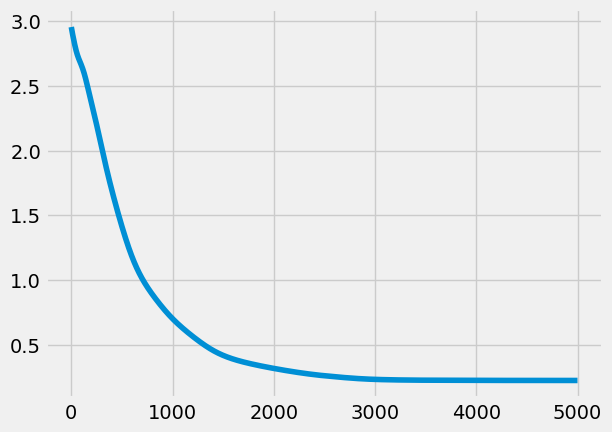

train accuracy = 0.8418367346938775
close but not quite: train accuracy = 0.8673469387755102
Inaccuracy =  0.06710129
Sum Inaccuracy =  39.455560594797134


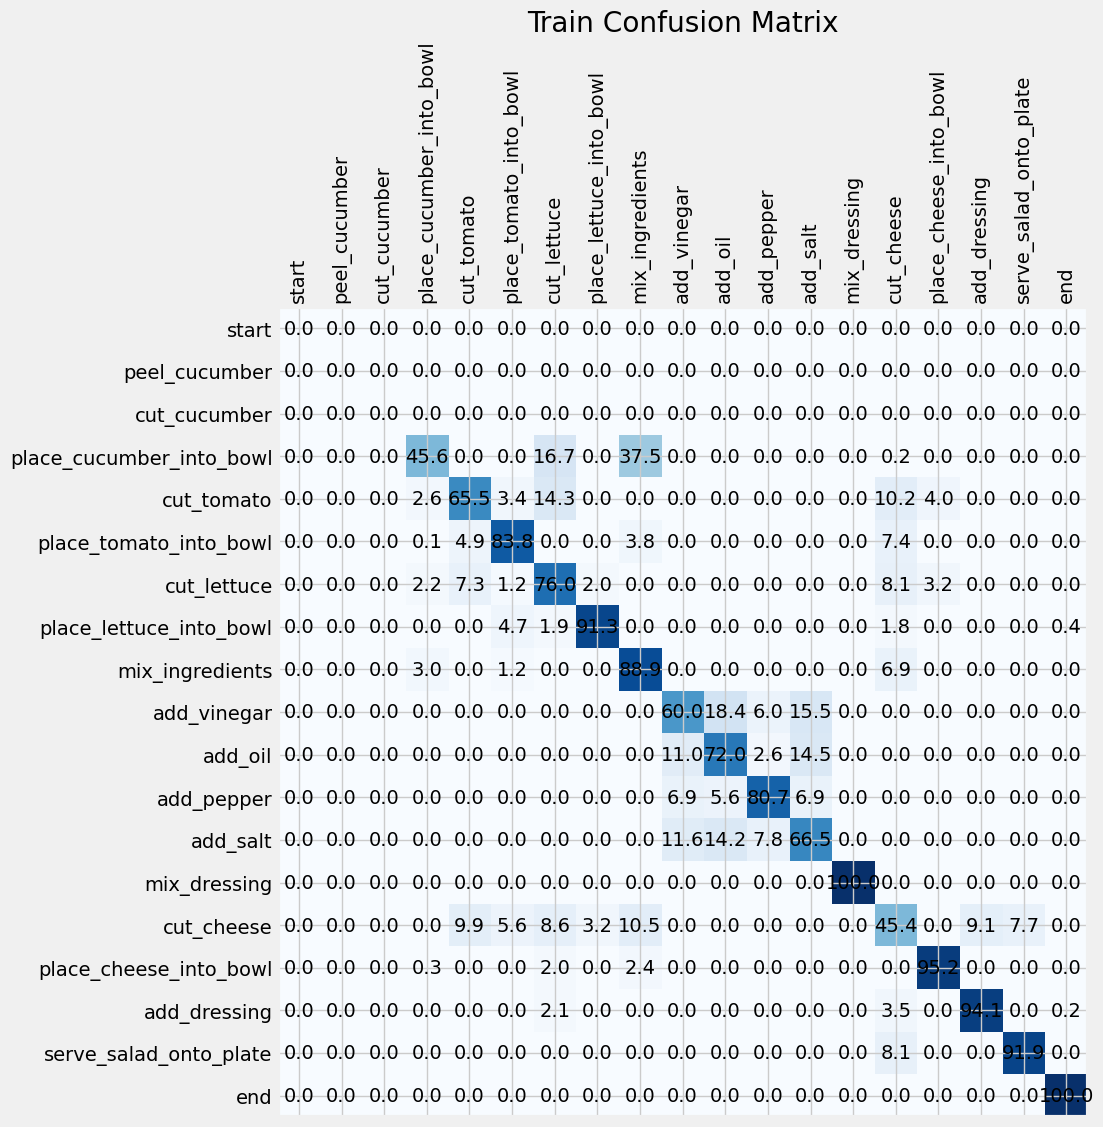


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5833473205566406, true_idx_val = 0.41633692383766174
inaccuracy  0.1670104


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.500094473361969, true_idx_val = 0.49906349182128906
inaccuracy  0.0010309815


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.66, 0.0, 0.0, 0.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.6634323000907898, true_idx_val = 0.33162298798561096
inaccuracy  0.3318093


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.7996477484703064, true_idx_val = 0.2003522664308548
inaccuracy  0.5992955


outputs [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.5, 0.0, 0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outputs_max = 0.5006067752838135, true_idx_val = 0.16695274412631989
inaccuracy  0.33365405


output

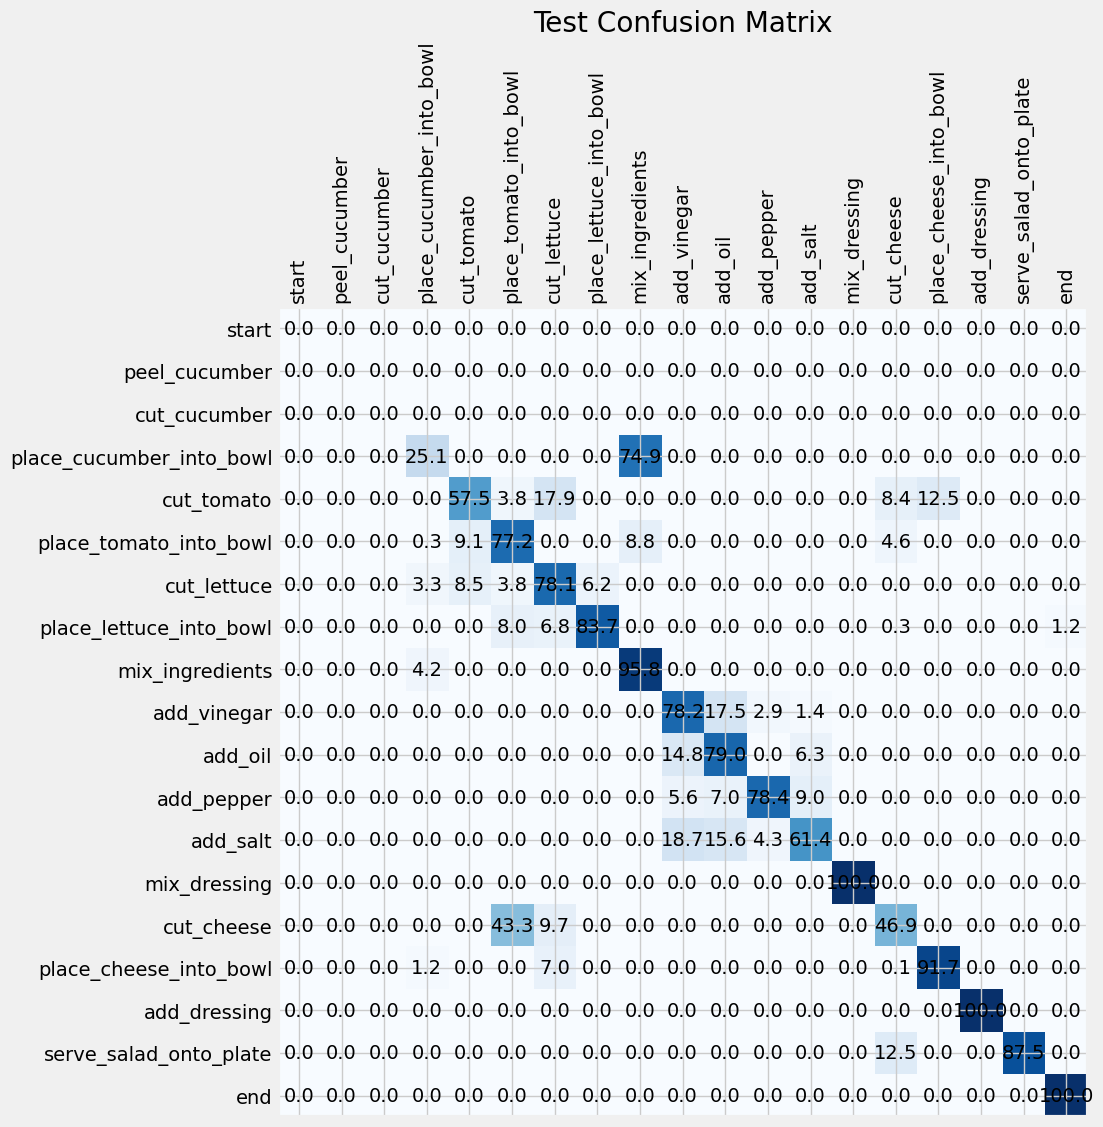

In [127]:
group_to_lstm = {}
for check_index in [None, 0, 1, 2]:
    lstm1 = train_lstm(stepsize, train_percent, check_index, num_classes, input_size, hidden_size, num_layers)
    group_to_lstm[check_index] = lstm1




# Test Belief Update

## Get new test data

In [128]:

count_correct = 0
total = 0
count_close = 0
test_true_list = []
test_pred_list = []
inaccuracy = []
all_inacc = []
conf_mat_dict = {}
for i in range(number_of_annots):
    for j in range(number_of_annots):
        conf_mat_dict[(i,j)] = []



for human_id in range(number_of_seqs_to_use):
#     print(f"human_id: {human_id}")
    beliefs = {0:1/4, 1:1/4, 2:1/4}
    max_key_list = []
    if human_id in train_indices:
        continue
    trial_id  = 1

    current_state = np.zeros(number_of_annots)
    seq = human_to_trial_num_to_sequence[human_id][trial_id]

    for i in range(len(seq)-stepsize):
        human_id_trainX = []
        human_id_trainY = []


        moving_window_x = []
        moving_window_y = []

        moving_window_x_annot_text = []
        moving_window_y_annot_text = []


        for j in range(stepsize):
            annot_idx = annot_to_num[seq[i+j]]
#             current_state[annot_idx] = current_state[annot_idx] + 1
            current_state = np.zeros(number_of_annots)

            current_state[annot_idx] = 1

            normalized_current_state = [elem/sum(current_state) for elem in current_state]

#             print("normalized_current_state", normalized_current_state)
            moving_window_x.extend(normalized_current_state)
            moving_window_x_annot_text.append(annot_idx)

        annot_idx = annot_to_num[seq[i+stepsize]]
        moving_window_y_annot_text.append(annot_idx)
#         current_state[annot_idx] = current_state[annot_idx] + 1
        current_state[annot_idx] = 1
        normalized_current_state = [elem for elem in current_state]
#         normalized_current_state = [elem for elem in current_state]
        moving_window_y.append(annot_idx)

        human_id_trainX.append(moving_window_x)
        human_id_trainY.append(moving_window_y)


        human_id_trainX = np.array(human_id_trainX)
        human_id_trainY = np.array(human_id_trainY)


        X_train_tensors = Variable(torch.Tensor(human_id_trainX))
        y_train_tensors = Variable(torch.Tensor(human_id_trainY))

        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

        group_to_inacc = {}
        group_to_inaccuracy = {}
        group_to_likelihood = {}
        group_to_pred = {}
        sum_inacc = 0
        true_idx = int(y_train_tensors.detach().numpy()[0][0])
        for group in [0,1,2]:
            lstm1 = group_to_lstm[group]
            outputs = lstm1.forward(X_train_tensors_final)
            outputs = outputs.detach().numpy()[0]

    #         min_outputs = min(outputs)
    #         if min_outputs < 0:
    #             outputs = [elem - min_outputs for elem in outputs]
    #         outputs /= sum(outputs)
    #         print("outputs", outputs)

            outputs = softmax(outputs)
            pred_idx = np.argmax(outputs)
#             true_idx = int(y_train_tensors.detach().numpy()[0][0])

            group_to_pred[group] = pred_idx
                
            test_true_list.append(true_idx)
            test_pred_list.append(pred_idx)

            outputs_max = np.max(outputs)
            true_idx_val = outputs[true_idx]
            max_dist = np.max(outputs)
            inaccuracy.append((outputs_max - true_idx_val))
            
            group_to_inacc[group] = (outputs_max - true_idx_val)
            group_to_inaccuracy[group] = (outputs_max - true_idx_val)
            sum_inacc += (outputs_max - true_idx_val)
            group_to_likelihood[group] = true_idx_val
            
            
#         sum_normed = 0
#         for group in group_to_inaccuracy:
#             if sum_inacc != 0:
#                 group_to_inaccuracy[group] = 1-(group_to_inaccuracy[group]/sum_inacc)
#                 sum_normed += 1-(group_to_inaccuracy[group]/sum_inacc)
            
#         group_to_accuracy = {}
#         sum_Z = 0
#         for group in group_to_inaccuracy:
#             if sum_normed != 0:
#                 group_to_accuracy[group]  = group_to_inaccuracy[group]/sum_normed
#             else:
#                 group_to_accuracy[group]  = group_to_inaccuracy[group]
                
#             beliefs[group] = group_to_accuracy[group]  * beliefs[group]
#             sum_Z +=  group_to_accuracy[group]  * beliefs[group]

        sum_Z = 0
        for group in group_to_likelihood:
            beliefs[group] = group_to_likelihood[group]  * beliefs[group]
            sum_Z +=  group_to_likelihood[group]  * beliefs[group]
            
        if sum_Z != 0:
            for group in beliefs:
                beliefs[group] /= sum_Z
                
        inacc = 0
        max_key = max(beliefs, key=beliefs.get)
        max_key_list.append(max_key)
        inacc += group_to_inacc[max_key]
        pred_idx = group_to_pred[max_key]
        if pred_idx == true_idx:
            count_correct += 1
                
        all_inacc.append(inacc)
#     plt.plot(range(len(max_key_list)), max_key_list, label='pred')   
#     plt.plot(range(len(max_key_list)), [labels[human_id]]* len(max_key_list), label='true')
#     plt.show()
#     plt.close()
        
        

In [129]:
np.mean(all_inacc)

0.06423557498270557

In [130]:
count_correct/len(all_inacc)

0.8178571428571428

In [131]:
beliefs

{0: 6.421478026741801e-103, 1: 1.0, 2: 4.868827164007511e-112}

In [137]:
def compute_test_accuracy_on_group(stepsize, train_percent, check_index, lstm1):

    count_correct = 0
    total = 0
    count_close = 0
    test_true_list = []
    test_pred_list = []
    inaccuracy = []
    conf_mat_dict = {}
    for i in range(number_of_annots):
        for j in range(number_of_annots):
            conf_mat_dict[(i,j)] = []

    # test_indices = np.random.choice(range(number_of_seqs_to_use), size=int(number_of_seqs_to_use*train_percent), replace=False)

    # for human_id in range(int(100*train_percent), 100):
    for human_id in range(number_of_seqs_to_use):
    #     print(f"human_id: {human_id}")
        if human_id in train_indices:
            continue
        trial_id  = 1

        if check_index is not None and labels[human_id] != check_index:
            continue

        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]

        for i in range(len(seq)-stepsize):
            human_id_trainX = []
            human_id_trainY = []


            moving_window_x = []
            moving_window_y = []

            moving_window_x_annot_text = []
            moving_window_y_annot_text = []


            for j in range(stepsize):
                annot_idx = annot_to_num[seq[i+j]]
    #             current_state[annot_idx] = current_state[annot_idx] + 1
                current_state = np.zeros(number_of_annots)

                current_state[annot_idx] = 1

                normalized_current_state = [elem/sum(current_state) for elem in current_state]

    #             print("normalized_current_state", normalized_current_state)
                moving_window_x.extend(normalized_current_state)
                moving_window_x_annot_text.append(annot_idx)

            annot_idx = annot_to_num[seq[i+stepsize]]
            moving_window_y_annot_text.append(annot_idx)
    #         current_state[annot_idx] = current_state[annot_idx] + 1
            current_state[annot_idx] = 1
            normalized_current_state = [elem for elem in current_state]
    #         normalized_current_state = [elem for elem in current_state]
            moving_window_y.append(annot_idx)

            human_id_trainX.append(moving_window_x)
            human_id_trainY.append(moving_window_y)


            human_id_trainX = np.array(human_id_trainX)
            human_id_trainY = np.array(human_id_trainY)


            X_train_tensors = Variable(torch.Tensor(human_id_trainX))
            y_train_tensors = Variable(torch.Tensor(human_id_trainY))
    #         print("Input X:", [num_to_annot[c] for c in moving_window_x_annot_text])

            X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    #         print("X_train_tensors_final", X_train_tensors_final)
            outputs = lstm1.forward(X_train_tensors_final)
            outputs = outputs.detach().numpy()[0]

    #         min_outputs = min(outputs)
    #         if min_outputs < 0:
    #             outputs = [elem - min_outputs for elem in outputs]
    #         outputs /= sum(outputs)
    #         print("outputs", outputs)

            outputs = softmax(outputs)
            pred_idx = np.argmax(outputs)
            true_idx = int(y_train_tensors.detach().numpy()[0][0])

            for j in range(len(outputs)):
                conf_mat_dict[(true_idx,j)].append(outputs[j])

    #         print(f"True Y: {true_idx}, {num_to_annot[true_idx]}, {outputs[true_idx]}" )
    #         print(f"Pred Y: {pred_idx}, {num_to_annot[pred_idx]}, {outputs[pred_idx]}" )

    #         print()

            test_true_list.append(true_idx)
            test_pred_list.append(pred_idx)

            outputs_max = np.max(outputs)
            true_idx_val = outputs[true_idx]
            max_dist = np.max(outputs)
            inaccuracy.append((outputs_max - true_idx_val))

            if abs(outputs_max - true_idx_val) < 0.1:
                count_close += 1
    #         outputs = [np.round(elem,2) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         num_nonzero = np.count_nonzero(outputs)
    #         outputs = [np.round(elem*num_nonzero,0) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         print("num_nonzero", num_nonzero)
    #         print("pred_idx", pred_idx)
    #         print("true_idx", true_idx)
    #         print(outputs == y_train_tensors.detach().numpy()[0])
            if (pred_idx == true_idx):
                count_correct += 1
#             else:
#                 print()
#                 print("outputs", [np.round(x, 2) for x in outputs])
#                 print(f"outputs_max = {outputs_max}, true_idx_val = {true_idx_val}")
#                 print("inaccuracy ",outputs_max - true_idx_val)
#                 print()
            total += 1
    #         break
    #     break

    print("test accuracy =", count_correct/total)
    print("close but not quite: test accuracy =", count_close/total)
    print("Inaccuracy = ", np.mean(inaccuracy))
    print("Sum Inaccuracy = ", sum(inaccuracy))


    conf_mat = np.zeros((number_of_annots, number_of_annots))

    for i in range(number_of_annots):
        for j in range(number_of_annots):
            if len(conf_mat_dict[(i,j)])!=0:
                conf_mat[i][j] = np.sum(conf_mat_dict[(i,j)])

    for i in range(number_of_annots):
        sum_across_row = sum(conf_mat[i,:])
        for j in range(number_of_annots):
            if sum_across_row!=0:
                conf_mat[i][j] = conf_mat[i][j]/sum_across_row

    fig, ax = plt.subplots(figsize=(10,10))


    ax.matshow(conf_mat, cmap=plt.cm.Blues)



    for i in np.arange(number_of_annots):
        for j in np.arange(number_of_annots):
            c = conf_mat[j,i]*100
            ax.text(i, j, str(np.round(c,1)), va='center', ha='center')

    x = np.arange(number_of_annots)
    return np.mean(inaccuracy), count_correct/total

#     plt.xticks(x, all_annotations, rotation='vertical')
#     plt.yticks(x, all_annotations, rotation='horizontal')
#     plt.title("Test Confusion Matrix")
#     plt.show()
#     plt.close()

In [138]:
def compute_test_accuracy_on_all(stepsize, train_percent, check_index, lstm1):

    count_correct = 0
    total = 0
    count_close = 0
    test_true_list = []
    test_pred_list = []
    inaccuracy = []
    conf_mat_dict = {}
    for i in range(number_of_annots):
        for j in range(number_of_annots):
            conf_mat_dict[(i,j)] = []

    # test_indices = np.random.choice(range(number_of_seqs_to_use), size=int(number_of_seqs_to_use*train_percent), replace=False)

    # for human_id in range(int(100*train_percent), 100):
    for human_id in range(number_of_seqs_to_use):
    #     print(f"human_id: {human_id}")
        if human_id in train_indices:
            continue
        trial_id  = 1

#         if check_index is not None and labels[human_id] != check_index:
#             continue

        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]

        for i in range(len(seq)-stepsize):
            human_id_trainX = []
            human_id_trainY = []


            moving_window_x = []
            moving_window_y = []

            moving_window_x_annot_text = []
            moving_window_y_annot_text = []


            for j in range(stepsize):
                annot_idx = annot_to_num[seq[i+j]]
    #             current_state[annot_idx] = current_state[annot_idx] + 1
                current_state = np.zeros(number_of_annots)

                current_state[annot_idx] = 1

                normalized_current_state = [elem/sum(current_state) for elem in current_state]

    #             print("normalized_current_state", normalized_current_state)
                moving_window_x.extend(normalized_current_state)
                moving_window_x_annot_text.append(annot_idx)

            annot_idx = annot_to_num[seq[i+stepsize]]
            moving_window_y_annot_text.append(annot_idx)
    #         current_state[annot_idx] = current_state[annot_idx] + 1
            current_state[annot_idx] = 1
            normalized_current_state = [elem for elem in current_state]
    #         normalized_current_state = [elem for elem in current_state]
            moving_window_y.append(annot_idx)

            human_id_trainX.append(moving_window_x)
            human_id_trainY.append(moving_window_y)


            human_id_trainX = np.array(human_id_trainX)
            human_id_trainY = np.array(human_id_trainY)


            X_train_tensors = Variable(torch.Tensor(human_id_trainX))
            y_train_tensors = Variable(torch.Tensor(human_id_trainY))
    #         print("Input X:", [num_to_annot[c] for c in moving_window_x_annot_text])

            X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    #         print("X_train_tensors_final", X_train_tensors_final)
            outputs = lstm1.forward(X_train_tensors_final)
            outputs = outputs.detach().numpy()[0]

    #         min_outputs = min(outputs)
    #         if min_outputs < 0:
    #             outputs = [elem - min_outputs for elem in outputs]
    #         outputs /= sum(outputs)
    #         print("outputs", outputs)

            outputs = softmax(outputs)
            pred_idx = np.argmax(outputs)
            true_idx = int(y_train_tensors.detach().numpy()[0][0])

            for j in range(len(outputs)):
                conf_mat_dict[(true_idx,j)].append(outputs[j])

    #         print(f"True Y: {true_idx}, {num_to_annot[true_idx]}, {outputs[true_idx]}" )
    #         print(f"Pred Y: {pred_idx}, {num_to_annot[pred_idx]}, {outputs[pred_idx]}" )

    #         print()

            test_true_list.append(true_idx)
            test_pred_list.append(pred_idx)

            outputs_max = np.max(outputs)
            true_idx_val = outputs[true_idx]
            max_dist = np.max(outputs)
            inaccuracy.append((outputs_max - true_idx_val))

            if abs(outputs_max - true_idx_val) < 0.1:
                count_close += 1
    #         outputs = [np.round(elem,2) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         num_nonzero = np.count_nonzero(outputs)
    #         outputs = [np.round(elem*num_nonzero,0) if abs(elem) > 0.05 else 0 for elem in outputs]
    #         print("num_nonzero", num_nonzero)
    #         print("pred_idx", pred_idx)
    #         print("true_idx", true_idx)
    #         print(outputs == y_train_tensors.detach().numpy()[0])
            if (pred_idx == true_idx):
                count_correct += 1
#             else:
#                 print()
#                 print("outputs", [np.round(x, 2) for x in outputs])
#                 print(f"outputs_max = {outputs_max}, true_idx_val = {true_idx_val}")
#                 print("inaccuracy ",outputs_max - true_idx_val)
#                 print()
            total += 1
    #         break
    #     break

    print("test accuracy =", count_correct/total)
    print("close but not quite: test accuracy =", count_close/total)
    print("Inaccuracy = ", np.mean(inaccuracy))
    print("Sum Inaccuracy = ", sum(inaccuracy))


    conf_mat = np.zeros((number_of_annots, number_of_annots))

    for i in range(number_of_annots):
        for j in range(number_of_annots):
            if len(conf_mat_dict[(i,j)])!=0:
                conf_mat[i][j] = np.sum(conf_mat_dict[(i,j)])

    for i in range(number_of_annots):
        sum_across_row = sum(conf_mat[i,:])
        for j in range(number_of_annots):
            if sum_across_row!=0:
                conf_mat[i][j] = conf_mat[i][j]/sum_across_row

    fig, ax = plt.subplots(figsize=(10,10))


    ax.matshow(conf_mat, cmap=plt.cm.Blues)



    for i in np.arange(number_of_annots):
        for j in np.arange(number_of_annots):
            c = conf_mat[j,i]*100
            ax.text(i, j, str(np.round(c,1)), va='center', ha='center')

    x = np.arange(number_of_annots)

#     plt.xticks(x, all_annotations, rotation='vertical')
#     plt.yticks(x, all_annotations, rotation='horizontal')
#     plt.title("Test Confusion Matrix")
#     plt.show()
#     plt.close()
    return np.mean(inaccuracy), count_correct/total

In [136]:
moe_inacc = np.mean(all_inacc)
moe_acc = count_correct/len(all_inacc)

In [167]:
group_to_all_inacc = {}
group_to_all_acc = {}

group_to_group_inacc = {}
group_to_group_acc = {}

for check_index in [None, 0, 1, 2]:
    print("check_index", check_index)
    lstm1 = group_to_lstm[check_index]
    print("TEST ON ALL")
    inacc, acc = compute_test_accuracy_on_all(stepsize, train_percent, check_index, lstm1)
    group_inacc, group_acc = compute_test_accuracy_on_group(stepsize, train_percent, check_index, lstm1)
    if check_index is None:
        check_index = 'Agg'
    group_to_all_inacc[check_index] = inacc
    group_to_all_acc[check_index] = acc
#     print("TEST ON GROUP")
    
    group_to_group_inacc[check_index] = group_inacc
    group_to_group_acc[check_index] = group_acc
#     print()
    




check_index None
TEST ON ALL
test accuracy = 0.7321428571428571
close but not quite: test accuracy = 0.7797619047619048
Inaccuracy =  0.08419551
Sum Inaccuracy =  70.72423155605793
test accuracy = 0.7321428571428571
close but not quite: test accuracy = 0.7797619047619048
Inaccuracy =  0.08419551
Sum Inaccuracy =  70.72423155605793
check_index 0
TEST ON ALL
test accuracy = 0.580952380952381
close but not quite: test accuracy = 0.6130952380952381
Inaccuracy =  0.243803
Sum Inaccuracy =  204.7945118546486
test accuracy = 0.7705627705627706
close but not quite: test accuracy = 0.803030303030303
Inaccuracy =  0.074409746
Sum Inaccuracy =  34.37730513513088
check_index 1
TEST ON ALL
test accuracy = 0.5023809523809524
close but not quite: test accuracy = 0.5095238095238095
Inaccuracy =  0.4163103
Sum Inaccuracy =  349.7006569355726
test accuracy = 0.8761904761904762
close but not quite: test accuracy = 0.8952380952380953
Inaccuracy =  0.03548089
Sum Inaccuracy =  7.4509865045547485
check_inde

In [162]:
group_to_all_inacc['MOE'] = moe_inacc
group_to_all_acc['MOE'] = moe_acc

In [147]:
group_to_all_inacc

{'Agg': 0.08419551,
 0: 0.243803,
 1: 0.4163103,
 2: 0.510072,
 'MOE': 0.06423557498270557}

In [170]:
plt.close()

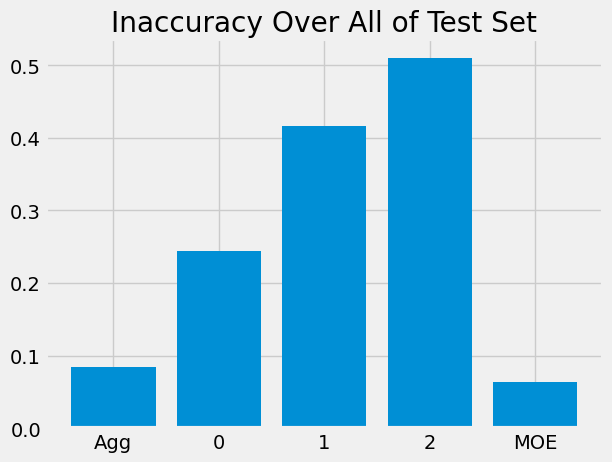

In [166]:
fig, ax = plt.subplots()
ax.bar(range(len(group_to_all_inacc.keys())), group_to_all_inacc.values())
ax.set_xticks(range(len(group_to_all_inacc.keys())))
ax.set_xticklabels(list(group_to_all_inacc.keys()))
plt.title("Inaccuracy Over All of Test Set")
plt.show()
plt.close()

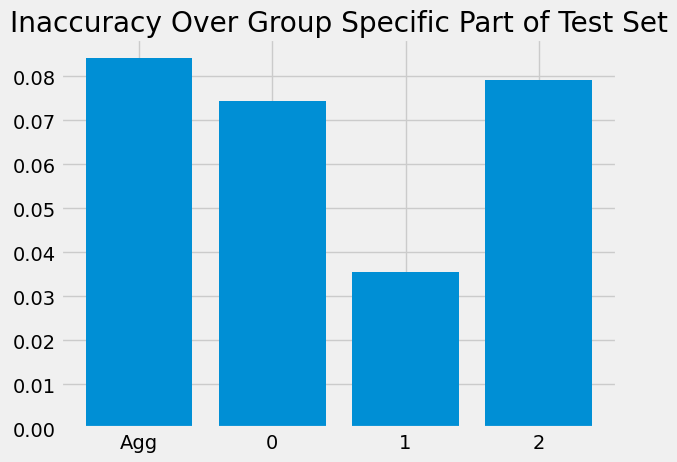

In [171]:
fig, ax = plt.subplots()
ax.bar(range(len(group_to_group_inacc.keys())), group_to_group_inacc.values())
ax.set_xticks(range(len(group_to_group_inacc.keys())))
ax.set_xticklabels(list(group_to_group_inacc.keys()))
plt.title("Inaccuracy Over Group Specific Part of Test Set")
plt.show()
plt.close()

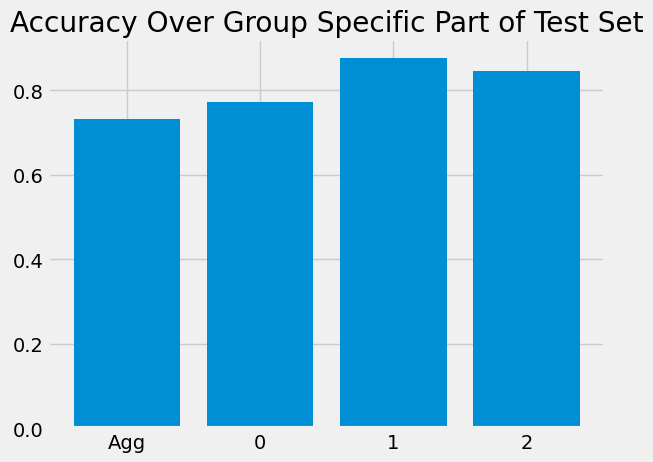

In [172]:
fig, ax = plt.subplots()
ax.bar(range(len(group_to_group_acc.keys())), group_to_group_acc.values())
ax.set_xticks(range(len(group_to_group_acc.keys())))
ax.set_xticklabels(list(group_to_group_acc.keys()))
plt.title("Accuracy Over Group Specific Part of Test Set")
plt.show()
plt.close()

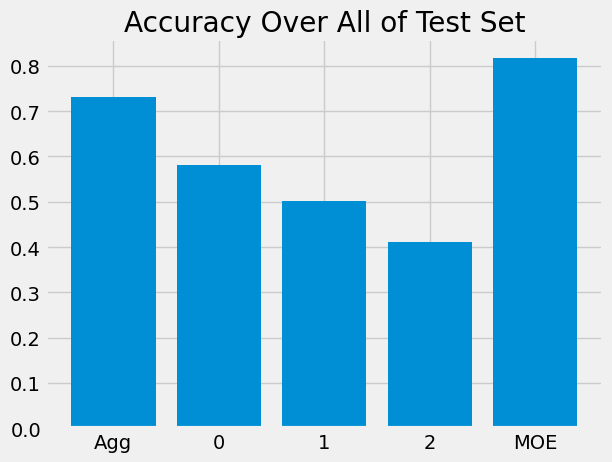

In [165]:
fig, ax = plt.subplots()
ax.bar(range(len(group_to_all_acc.keys())), group_to_all_acc.values())
ax.set_xticks(range(len(group_to_all_acc.keys())))
ax.set_xticklabels(list(group_to_all_acc.keys()))
plt.title("Accuracy Over All of Test Set")
plt.show()
plt.close()